<a href="https://colab.research.google.com/github/COS-IT-FLOWS/Impacts/blob/main/Elevation_coastal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import osgeo.gdal as gdal
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, ogr
from osgeo import ogr
from google.colab import drive


In [ ]:

def process_raster_data(input_filename, output_filename, output_vector_filename, threshold):
    # Open the raster file
    gdal_data = gdal.Open(input_filename)

    # Check if the raster file was opened successfully
    if gdal_data is None:
        print(f"Failed to open the raster file: {input_filename}")
        return  # Exit the function if the file cannot be opened

    # Get the first raster band
    gdal_band = gdal_data.GetRasterBand(1)

    # Get the no-data value
    nodataval = gdal_band.GetNoDataValue()
    print(f"No Data Value: {nodataval}")

    # Continue with your processing...
    # Convert the TIFF data to a numpy array
    data_array = gdal_data.ReadAsArray().astype(float)

    # Replace missing values with NaN if necessary
    # if np.any(data_array == nodataval):
    #     data_array[data_array == nodataval] = np.nan

    # Convert raster grid values: set values <= threshold as 1 and others as -9999.9
    data_array = np.where(np.logical_and(data_array > nodataval, data_array <= threshold), 1, -9999.9)

    # gdal_band.SetNoDataValue(-9999.9)

    # Create a new TIFF file
    driver = gdal.GetDriverByName('GTiff')
    output_data = driver.Create(output_filename, data_array.shape[1], data_array.shape[0], 1, gdal.GDT_Float32)

    # Set the geotransform and projection from the original file
    output_data.SetGeoTransform(gdal_data.GetGeoTransform())
    output_data.SetProjection(gdal_data.GetProjection())

    # Write the modified array to the new file
    output_band = output_data.GetRasterBand(1)
    output_band.WriteArray(data_array)

    # Close the output file
    output_data = None

    # Plot the modified raster data
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Modified Raster Data (Threshold: {threshold})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.imshow(data_array, cmap="inferno", extent=(gdal_data.GetGeoTransform()[0],
                                                gdal_data.GetGeoTransform()[0] + gdal_data.GetGeoTransform()[1] * data_array.shape[1],
                                                gdal_data.GetGeoTransform()[3] + gdal_data.GetGeoTransform()[5] * data_array.shape[0],
                                                gdal_data.GetGeoTransform()[3]))

    ax.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust layout to fit the figure area

    plt.show()


    # Convert the modified raster to a vector shapefile in WGS 84 projection
    raster_to_vector(output_filename, output_vector_filename)



In [ ]:
def raster_to_vector(input_raster, output_vector):
    """
    Convert a raster file to a vector shapefile with an attribute table.

    Args:
        input_raster (str): The path to the input raster file.
        output_vector (str): The path to the output vector shapefile.
    """

    # Open raster dataset
    raster_ds = gdal.Open(input_raster)

    if raster_ds is None:
        raise Exception(f"Could not open raster file {input_raster}")

    # Get the raster band
    raster_band = raster_ds.GetRasterBand(1)

    # Get the no-data value
    no_data_value = raster_band.GetNoDataValue()

    # Create output vector file with WGS 84 projection
    driver = ogr.GetDriverByName("ESRI Shapefile")
    vector_ds = driver.CreateDataSource(output_vector)

    if vector_ds is None:
        raise Exception(f"Could not create vector file {output_vector}")

    # Define WGS 84 spatial reference
    srs = ogr.osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # EPSG code for WGS 84

    # Create layer with specified spatial reference
    layer = vector_ds.CreateLayer("layer", srs=srs, geom_type=ogr.wkbPolygon)
   # Add fields to store the value (1 or 0) and FID
    field_defn_value = ogr.FieldDefn("Value", ogr.OFTInteger)
    layer.CreateField(field_defn_value)

    field_defn_fid = ogr.FieldDefn("FID", ogr.OFTInteger)
    layer.CreateField(field_defn_fid)
    # Create a mask to select only pixels with value 1
    mask_array = raster_band.ReadAsArray() == 1
    mask_band = gdal.GetDriverByName('MEM').Create('', raster_band.XSize, raster_band.YSize, 1, gdal.GDT_Byte)
    mask_band.GetRasterBand(1).WriteArray(mask_array.astype(int))

    # Polygonize with mask
    gdal.Polygonize(raster_band, mask_band.GetRasterBand(1), layer, 0, [], callback=None)

    # Assign unique identifiers to each feature
    for fid, feature in enumerate(layer):
        feature.SetField("FID", fid)  # Set the FID field to the current index
        layer.SetFeature(feature)
    # Clean up
    raster_ds = None
    vector_ds = None

    # Print projection success message
    print("Projection to EPSG:4326 successful.")

    # Print the generated attribute table
    print_attribute_table(output_vector)



In [ ]:
def print_attribute_table(vector_file):
    """
    Print the attribute table of the vector shapefile, including bounding box coordinates.

    Args:
        vector_file (str): The path to the vector shapefile.
    """
    # Open the vector dataset
    vector_ds = ogr.Open(vector_file)

    if vector_ds is None:
        raise Exception(f"Could not open vector file {vector_file}")

    # Get the first layer
    layer = vector_ds.GetLayer(0)

    # Print the attribute table header
    print("Attribute Table:")
    print("FID\tValue\tMinX\tMinY\tMaxX\tMaxY")

    # Dictionary to count occurrences of each value
    value_count = {}

    # Iterate through the features and print the attributes
    for feature in layer:
        fid = feature.GetFID()
        # Feature ID
        value = feature.GetField("Value")  # Get the value field
        geometry = feature.GetGeometryRef()  # Get the geometry

        # Get bounding box coordinates
        envelope = geometry.GetEnvelope()  # Returns (minX, maxX, minY, maxY)
        min_x, max_x, min_y, max_y = envelope

        print(f"{fid}\t{value}\t{min_x}\t{min_y}\t{max_x}\t{max_y}")
        # Count occurrences of each value
        if value in value_count:
            value_count[value] += 1
        else:
            value_count[value] = 1

    # Print counts of values present in the polygons
    print("\nCount of Values Present in Polygons:")
    for val, count in value_count.items():
        print(f"Value: {val}, Count: {count}")


    # Clean up
    vector_ds = None


No Data Value: -9999.990234375


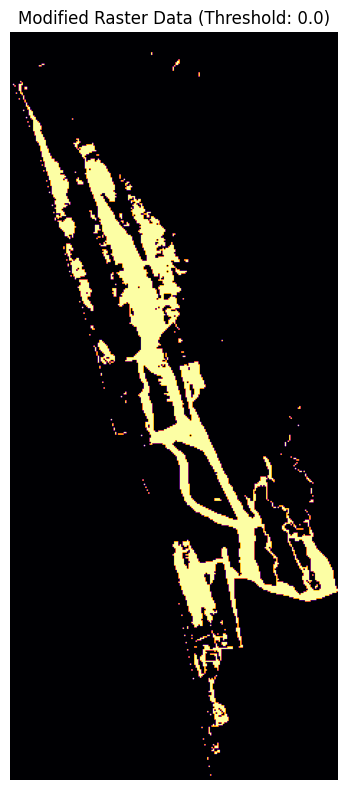

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


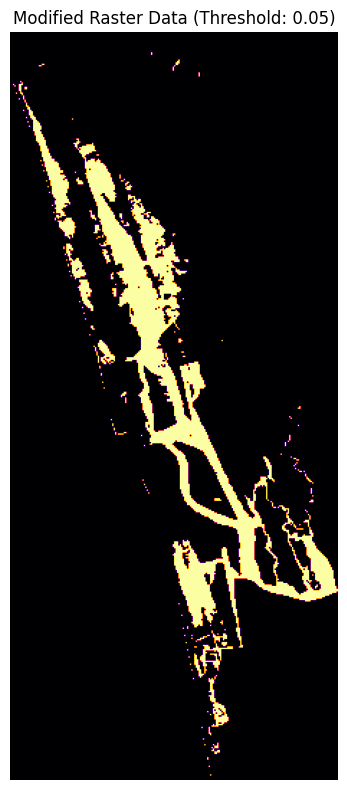

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


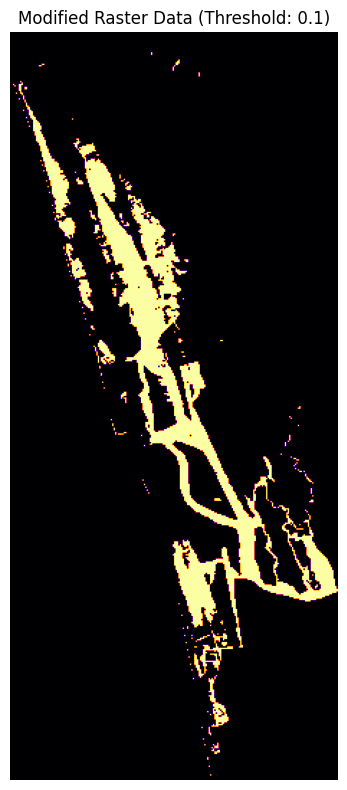

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


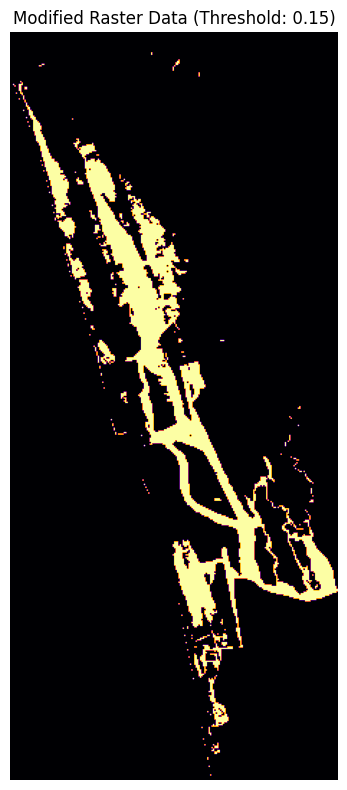

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


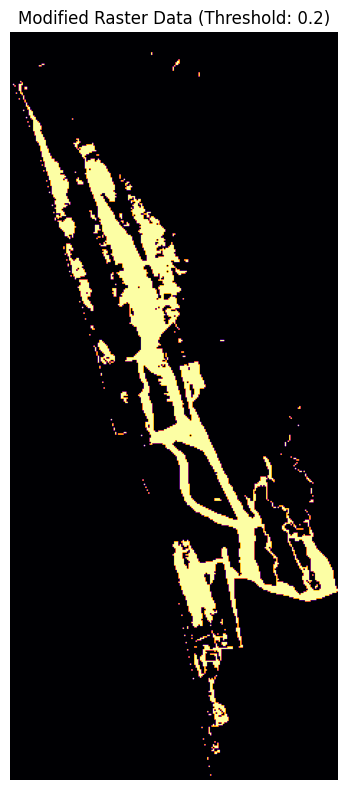

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


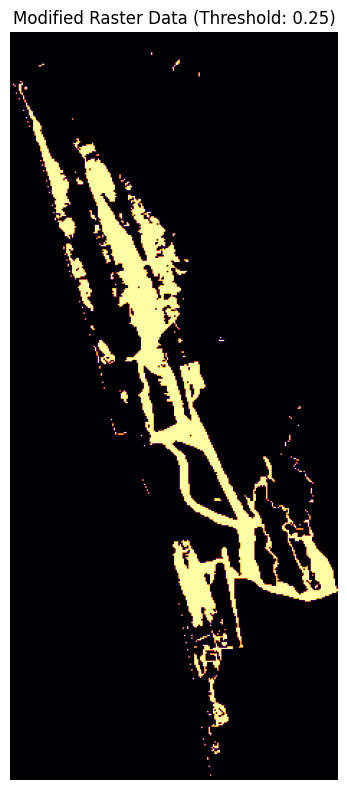

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


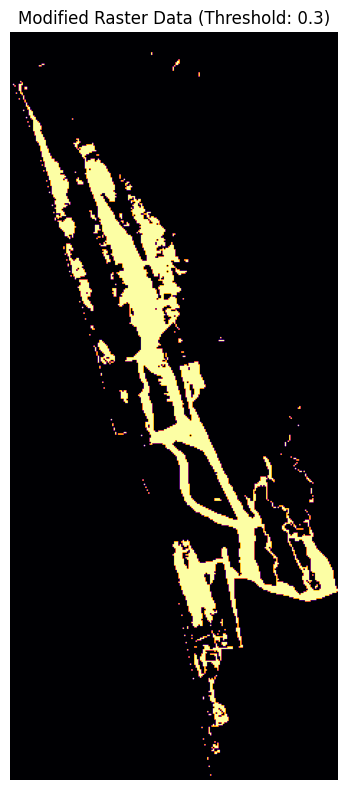

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


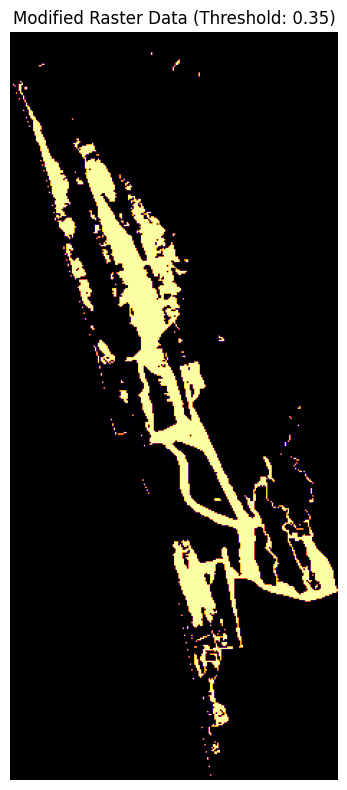

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


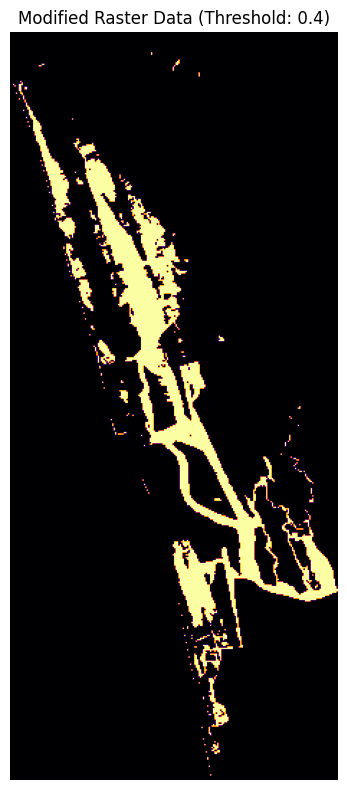

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


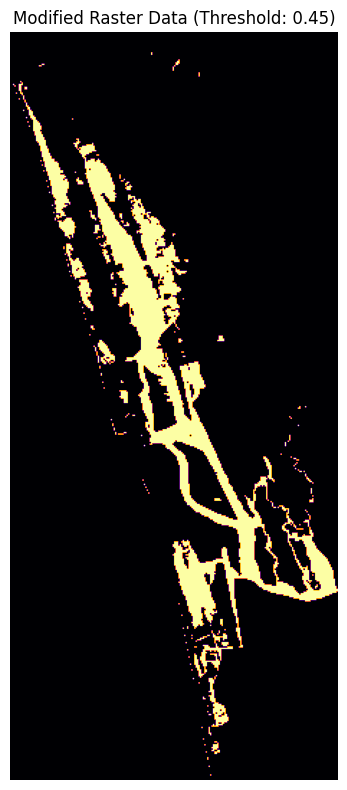

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
1	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
2	1	76.181515411	10.188176566500001	76.18318069	10.189009206000001
3	1	76.179850132	10.187343927	76.181515411	10.188176566500001
4	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
5	1	76.2572856055	10.184846008500001	76.25811824499999	10.187343927
6	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
7	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
8	1	76.164862621	10.1765196135	76.1656952605	10.177352253
9	1	76.168193179	10.170691137	76.1706910975	10.178184892500001
10	1	76.1656952605	10.175686974000001	76.1665279	10.1765196135
11	1	76.171523737	10.174021695	76.17318901600001	10.175686974000001
12	1	76.1665279	10.1715237765	76.16736053950001	10.172356416000001
13	1	76.1706910975	10.1681932185	76.171523737	10.170691137


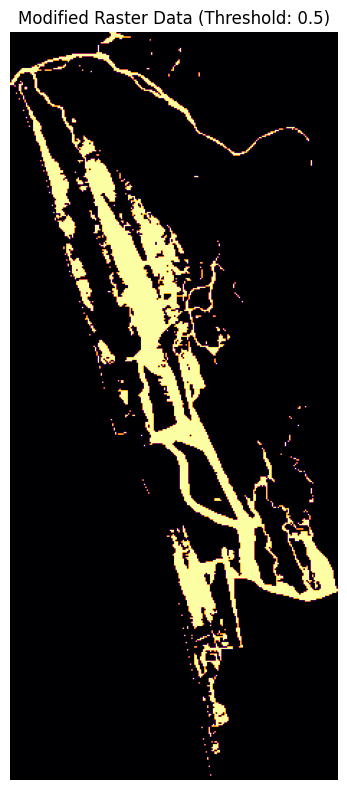

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
4	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
5	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
6	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
7	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
8	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
9	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
10	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
11	1	76.256452966	10.184846008500001	76.25811824499999	10.187343927
12	1	76.209825154	10.184013369	76.2106577935	10.184846008500001
13	1	76.2722731165	10.181515450500001	76.27310575599999	10.1

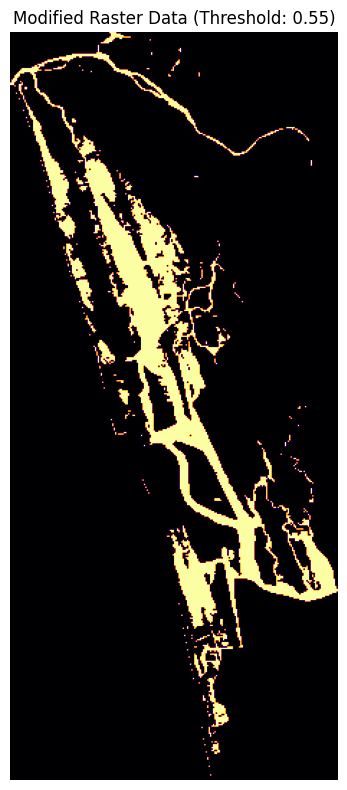

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
4	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
5	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
6	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
7	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
8	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
9	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
10	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
11	1	76.256452966	10.184846008500001	76.25811824499999	10.187343927
12	1	76.209825154	10.184013369	76.2106577935	10.184846008500001
13	1	76.2722731165	10.181515450500001	76.27310575599999	10.1

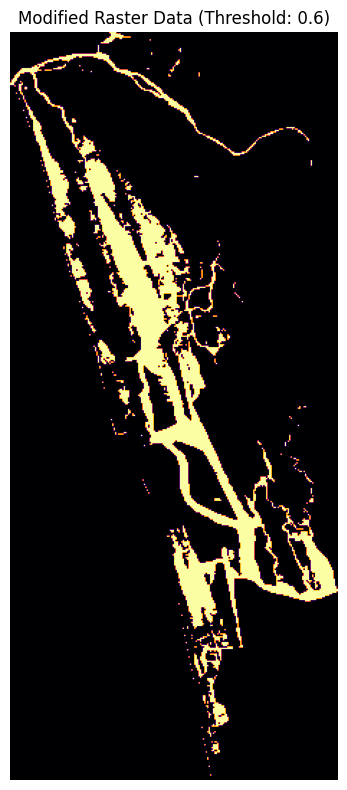

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
4	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
5	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
6	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
7	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
8	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
9	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
10	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
11	1	76.2556203265	10.184013369	76.25811824499999	10.187343927
12	1	76.209825154	10.184013369	76.2106577935	10.184846008500001
13	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013

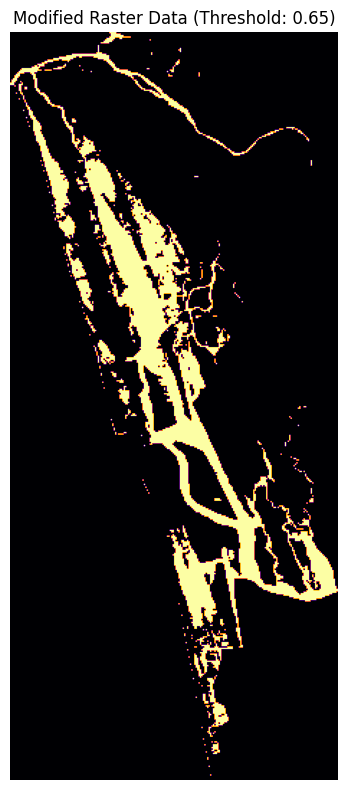

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.194005043	76.2456286525	10.195670322000002
4	1	76.2589508845	10.188176566500001	76.261448803	10.191507124500001
5	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
6	1	76.25811824499999	10.187343927	76.2589508845	10.188176566500001
7	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
8	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
9	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
10	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
11	1	76.2556203265	10.184013369	76.25811824499999	10.187343927
12	1	76.209825154	10.184013369	76.2106577935	10.184846008500001
13	1	76.2539550475	10.184013369	76.254787687	10.184846008500001
1

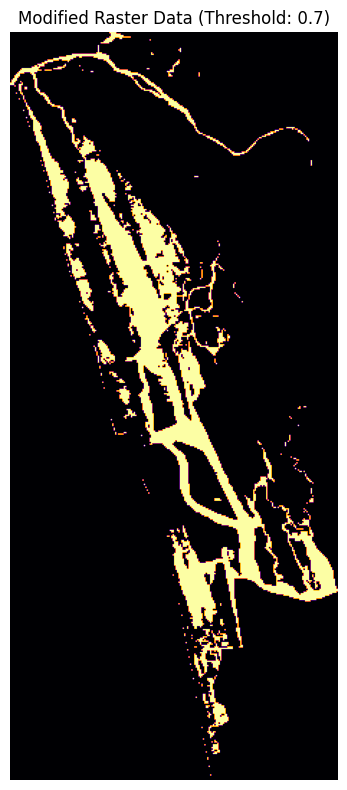

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.194005043	76.24646129199999	10.195670322000002
4	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
5	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
6	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
7	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
8	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
9	1	76.209825154	10.184013369	76.211490433	10.184846008500001
10	1	76.2539550475	10.181515450500001	76.261448803	10.191507124500001
11	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
12	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
13	1	76.168193179	10.170691137	76.1706910975	10.17

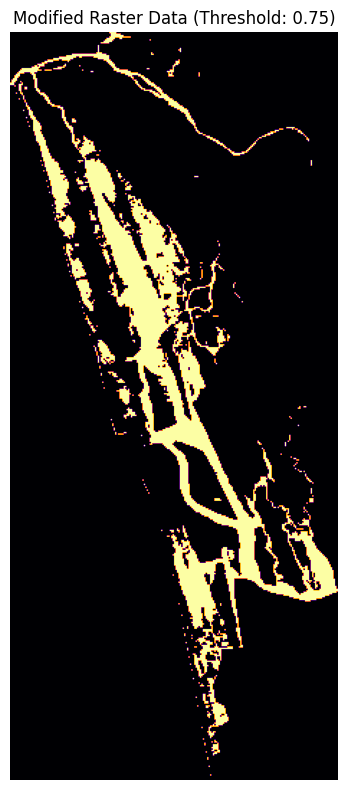

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.194005043	76.24646129199999	10.195670322000002
4	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
5	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
6	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
7	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
8	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
9	1	76.209825154	10.184013369	76.211490433	10.184846008500001
10	1	76.2539550475	10.181515450500001	76.261448803	10.191507124500001
11	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
12	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
13	1	76.168193179	10.170691137	76.1706910975	10.17

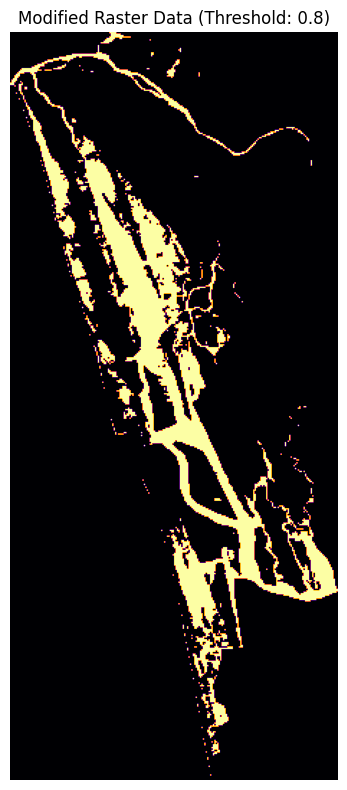

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.1931724035	76.24646129199999	10.195670322000002
4	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
5	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
6	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
7	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
8	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
9	1	76.209825154	10.184013369	76.211490433	10.184846008500001
10	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
11	1	76.2539550475	10.180682811	76.261448803	10.191507124500001
12	1	76.1690258185	10.178184892500001	76.16985845800001	10.179017532000001
13	1	76.168193179	10.170691137	76.1706910975	10.1781848

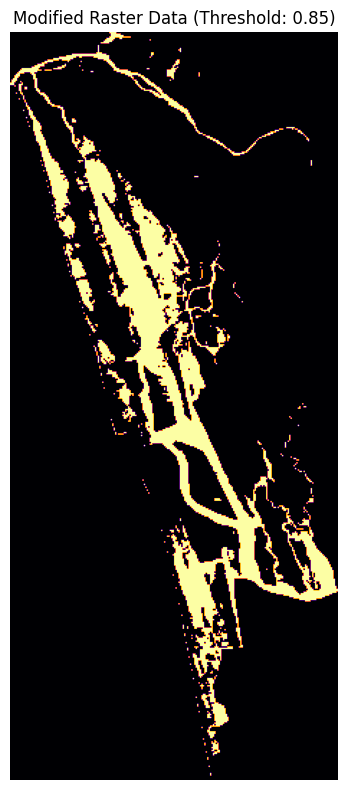

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.1931724035	76.24646129199999	10.195670322000002
4	1	76.2439633735	10.192339764000002	76.244796013	10.1931724035
5	1	76.2039966775	10.1898418455	76.204829317	10.190674485
6	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
7	1	76.259783524	10.1865112875	76.2606161635	10.187343927
8	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
9	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
10	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
11	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
12	1	76.209825154	10.184013369	76.211490433	10.184846008500001
13	1	76.2539550475	10.1798501715	76.261448803	10.191507124500001
14	1	76.2722731

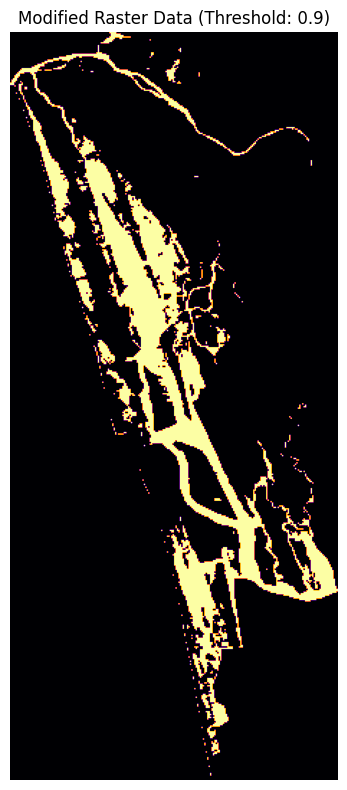

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2156536305	10.200666159	76.23313906	10.207327275
2	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
3	1	76.244796013	10.1931724035	76.24646129199999	10.195670322000002
4	1	76.2439633735	10.192339764000002	76.244796013	10.1931724035
5	1	76.2039966775	10.1898418455	76.204829317	10.190674485
6	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
7	1	76.259783524	10.1865112875	76.2606161635	10.187343927
8	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
9	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
10	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
11	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
12	1	76.209825154	10.184013369	76.211490433	10.184846008500001
13	1	76.253122408	10.178184892500001	76.261448803	10.191507124500001
14	1	76.272

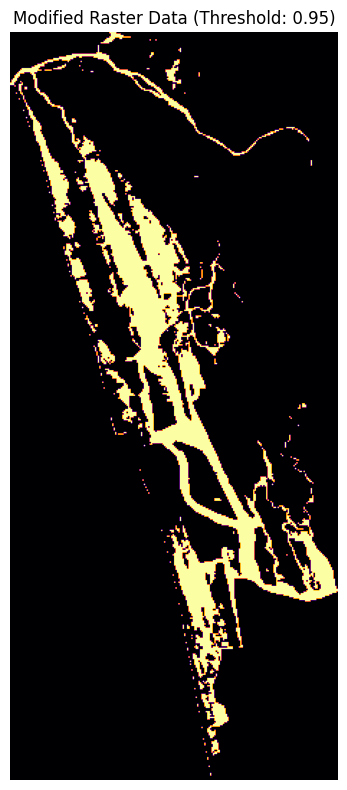

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
1	1	76.2472939315	10.202331438000002	76.248126571	10.2031640775
2	1	76.2156536305	10.200666159	76.23313906	10.207327275
3	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
4	1	76.2439633735	10.192339764000002	76.24646129199999	10.195670322000002
5	1	76.2039966775	10.1898418455	76.204829317	10.190674485
6	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
7	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
8	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
9	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
10	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
11	1	76.209825154	10.184013369	76.211490433	10.184846008500001
12	1	76.2722731165	10.181515450500001	76.27310575599999	10.184013369
13	1	76.253122408	10.177352253	76.2622814425	10.191507124500001


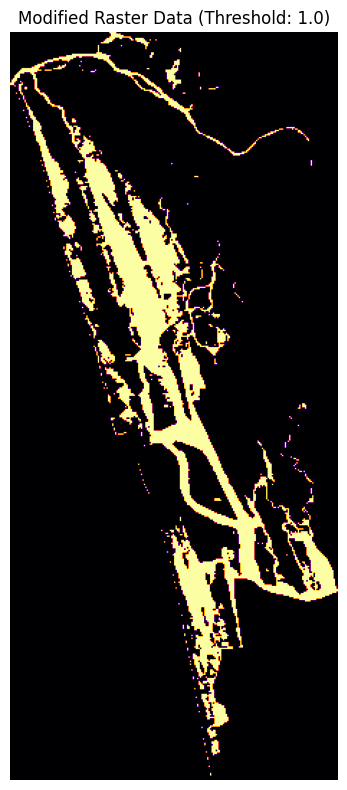

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
2	1	76.2472939315	10.202331438000002	76.248126571	10.2031640775
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
6	1	76.2439633735	10.192339764000002	76.24646129199999	10.195670322000002
7	1	76.2039966775	10.1898418455	76.204829317	10.190674485
8	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
9	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
10	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
11	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
12	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
13	1	76.2123230725	10.184846008500001	76.213155712	10.185678648000001
1

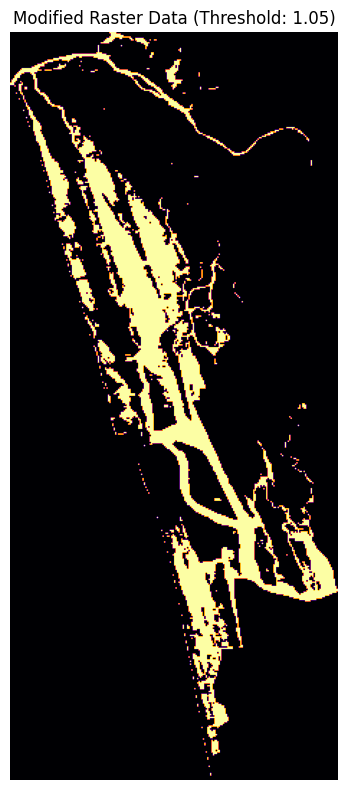

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
2	1	76.24646129199999	10.202331438000002	76.248126571	10.2031640775
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
6	1	76.2439633735	10.192339764000002	76.24646129199999	10.195670322000002
7	1	76.2039966775	10.1898418455	76.204829317	10.190674485
8	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
9	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
10	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
11	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
12	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
13	1	76.2123230725	10.184846008500001	76.2139883515	10.185678648000

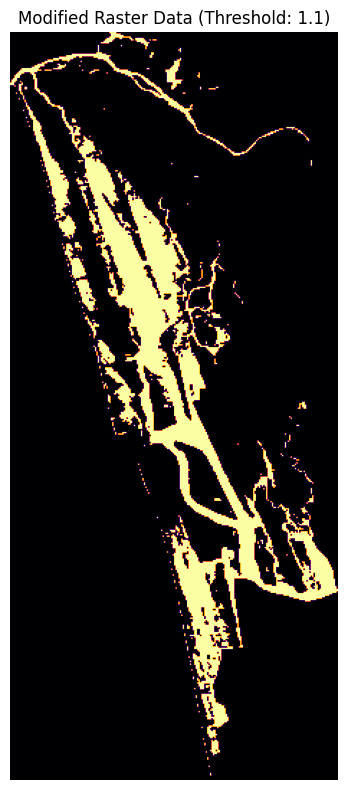

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
2	1	76.2456286525	10.202331438000002	76.248126571	10.2031640775
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
6	1	76.2439633735	10.192339764000002	76.24646129199999	10.195670322000002
7	1	76.2039966775	10.1898418455	76.204829317	10.190674485
8	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
9	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
10	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
11	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
12	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
13	1	76.2089925145	10.1831807295	76.214820991	10.185678648000001
14	1	7

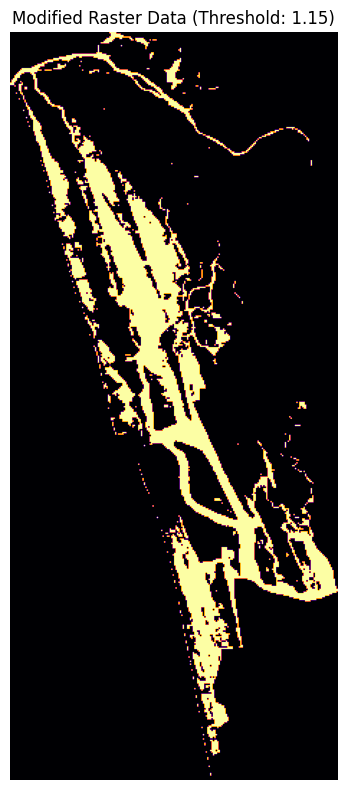

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
2	1	76.2456286525	10.202331438000002	76.248126571	10.2031640775
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
6	1	76.2439633735	10.191507124500001	76.24646129199999	10.195670322000002
7	1	76.2039966775	10.1898418455	76.204829317	10.190674485
8	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
9	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
10	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
11	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
12	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
13	1	76.2089925145	10.1831807295	76.214820991	10.185678648000001
14	1	7

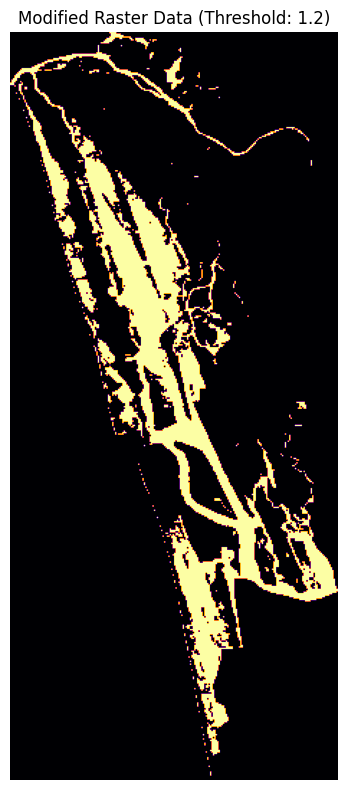

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
2	1	76.2456286525	10.201498798500001	76.248126571	10.2031640775
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
6	1	76.2439633735	10.191507124500001	76.24646129199999	10.195670322000002
7	1	76.2039966775	10.1898418455	76.204829317	10.190674485
8	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
9	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
10	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
11	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
12	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
13	1	76.2089925145	10.1831807295	76.214820991	10.185678648000001
14	1	7

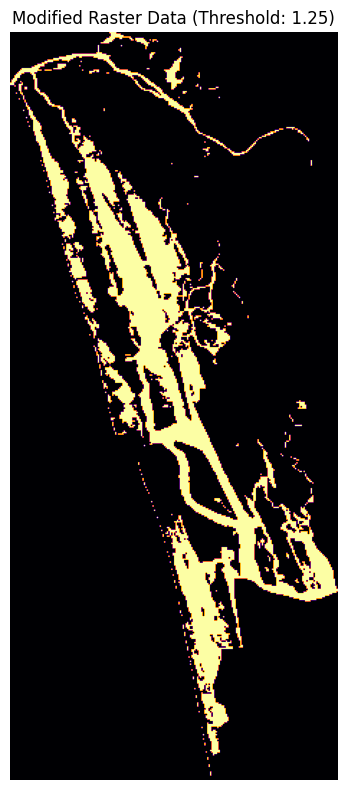

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
2	1	76.2456286525	10.201498798500001	76.248126571	10.2031640775
3	1	76.248126571	10.201498798500001	76.2489592105	10.202331438000002
4	1	76.2156536305	10.200666159	76.234804339	10.207327275
5	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
6	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
7	1	76.2439633735	10.191507124500001	76.2472939315	10.195670322000002
8	1	76.2039966775	10.1898418455	76.204829317	10.190674485
9	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
10	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
11	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
12	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
13	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001
14	1	

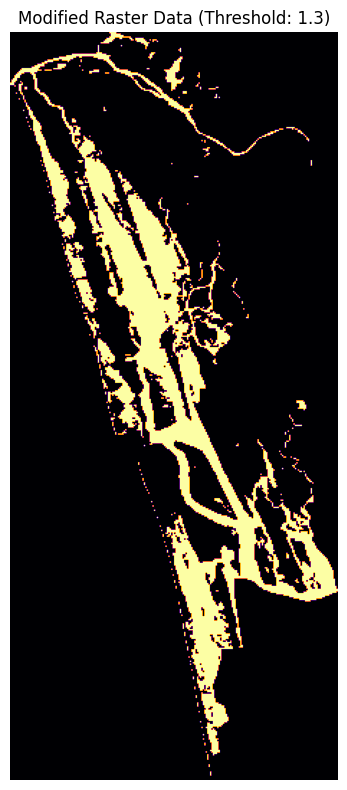

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.202331438000002	76.244796013	10.2031640775
2	1	76.2456286525	10.201498798500001	76.248126571	10.2031640775
3	1	76.248126571	10.201498798500001	76.2489592105	10.202331438000002
4	1	76.2156536305	10.200666159	76.234804339	10.207327275
5	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
6	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
7	1	76.243130734	10.191507124500001	76.2472939315	10.195670322000002
8	1	76.2039966775	10.1898418455	76.204829317	10.191507124500001
9	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
10	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
11	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
12	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
13	1	76.204829317	10.184846008500001	76.2056619565	10.185678648000001


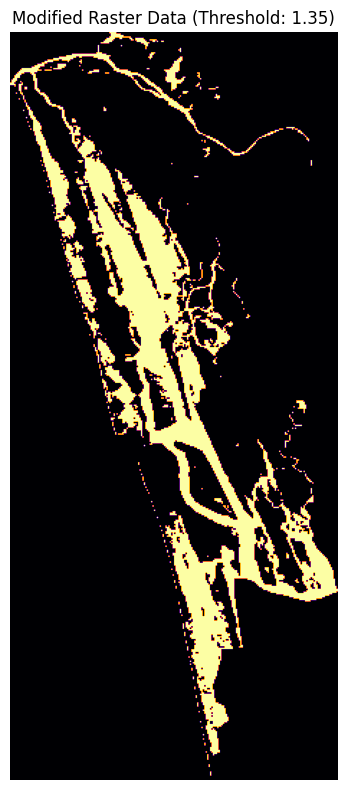

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.201498798500001	76.248126571	10.2031640775
2	1	76.248126571	10.201498798500001	76.2489592105	10.202331438000002
3	1	76.2506244895	10.201498798500001	76.25228976849999	10.202331438000002
4	1	76.2156536305	10.200666159	76.234804339	10.207327275
5	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
6	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
7	1	76.243130734	10.191507124500001	76.2472939315	10.195670322000002
8	1	76.203164038	10.189009206000001	76.204829317	10.191507124500001
9	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
10	1	76.186511248	10.1865112875	76.1873438875	10.187343927
11	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
12	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
13	1	76.18318069	10.184846008500001	76.1873438875	10.1856786480000

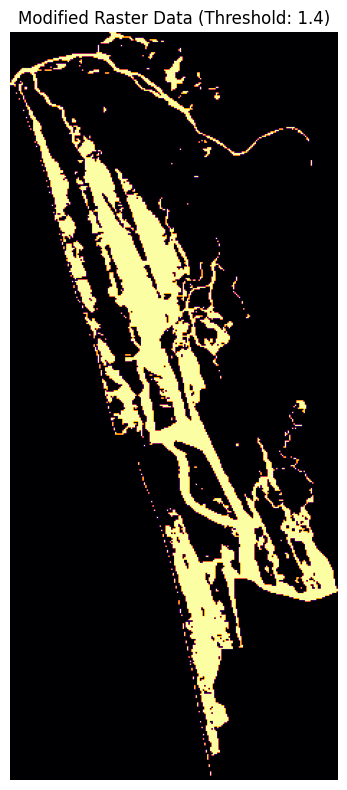

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.201498798500001	76.2489592105	10.2031640775
2	1	76.2506244895	10.201498798500001	76.25228976849999	10.202331438000002
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
6	1	76.239800176	10.1931724035	76.24063281549999	10.194005043
7	1	76.243130734	10.191507124500001	76.2472939315	10.195670322000002
8	1	76.203164038	10.189009206000001	76.204829317	10.191507124500001
9	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
10	1	76.186511248	10.1865112875	76.1873438875	10.187343927
11	1	76.188176527	10.185678648000001	76.1956702825	10.189009206000001
12	1	76.2422980945	10.185678648000001	76.2439633735	10.1865112875
13	1	76.18318069	10.184846008500001	76.1873438875	10.185678648000001
14	

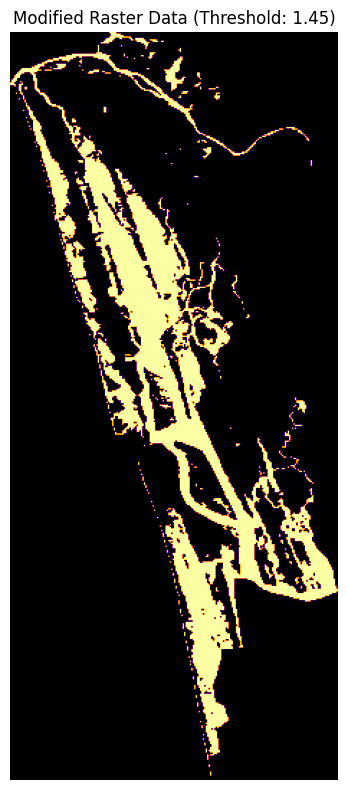

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.201498798500001	76.2489592105	10.2031640775
2	1	76.2506244895	10.201498798500001	76.25228976849999	10.202331438000002
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2606161635	10.195670322000002	76.2622814425	10.198168240500001
6	1	76.2289758625	10.1931724035	76.229808502	10.194837682500001
7	1	76.2389675365	10.1931724035	76.24063281549999	10.194005043
8	1	76.2306411415	10.192339764000002	76.231473781	10.1931724035
9	1	76.243130734	10.191507124500001	76.2472939315	10.195670322000002
10	1	76.234804339	10.191507124500001	76.2356369785	10.192339764000002
11	1	76.203164038	10.189009206000001	76.204829317	10.191507124500001
12	1	76.203164038	10.187343927	76.2039966775	10.188176566500001
13	1	76.186511248	10.1865112875	76.1873438875	10.187343927
14	1	76

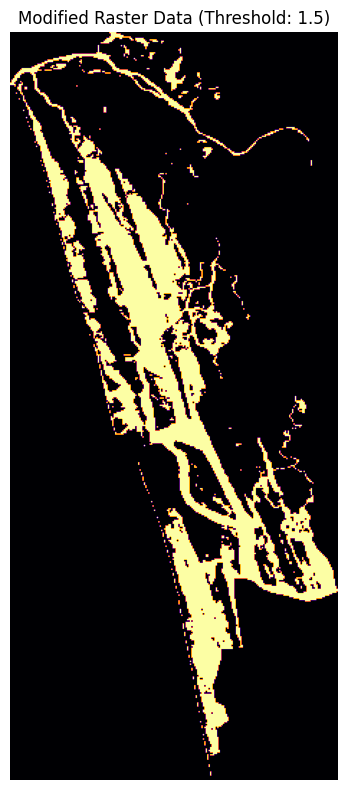

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.2356369785	10.197335601	76.2439633735	10.203996717
1	1	76.2439633735	10.201498798500001	76.2489592105	10.2031640775
2	1	76.2506244895	10.200666159	76.25228976849999	10.202331438000002
3	1	76.2156536305	10.200666159	76.234804339	10.207327275
4	1	76.2273105835	10.199000880000002	76.228143223	10.1998335195
5	1	76.2289758625	10.194005043	76.2323064205	10.1998335195
6	1	76.2606161635	10.194837682500001	76.2622814425	10.198168240500001
7	1	76.2289758625	10.1931724035	76.229808502	10.194837682500001
8	1	76.2389675365	10.1931724035	76.24063281549999	10.194005043
9	1	76.2306411415	10.192339764000002	76.231473781	10.1931724035
10	1	76.243130734	10.191507124500001	76.2472939315	10.195670322000002
11	1	76.234804339	10.191507124500001	76.2356369785	10.192339764000002
12	1	76.2356369785	10.190674485	76.236469618	10.191507124500001
13	1	76.203164038	10.189009206000001	76.204829317	10.191507124500001
14	1	76.2031

In [ ]:
# Example usage:
input_tiff = "/content/drive/MyDrive/colab files/coastalEKMNw_DEM.tif"
thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
        0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
        1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
        1.50]
# thresholds = [12.48]
for threshold in thresholds:
    output_tiff = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}coastalelevation.tif"
    output_shp = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"

    process_raster_data(input_tiff, output_tiff, output_shp, threshold) # changed 'thresholds' to 'threshold'

For Impact evaluation
1.Buildings

In [ ]:
import geopandas as gpd
import pandas as pd  # Import the pandas library with the alias 'pd'
from tabulate import tabulate

# Define the output shapefile path for shp1
thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
        0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
        1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
        1.50]
output_directory = "/content/drive/MyDrive/Coastal_panchayats/area"  # Specify the output directory

for threshold in thresholds:
    output_shp = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"

    # Load the shapefile (shp1) without changing its CRS
    shp1_gdf = gpd.read_file(output_shp)
    print("Original CRS of shp1:", shp1_gdf.crs)  # Check the original CRS

    # Reproject shp1 to WGS 84 (EPSG:4326)
    shp1_gdf = shp1_gdf.to_crs(epsg=4326)
    print("Reprojected CRS of shp1 to WGS 84:", shp1_gdf.crs)  # Confirm the reprojection

    # Load the boundary shapefile (shp2) and reproject to WGS 84
    boundary_gdf = gpd.read_file('/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp')
    boundary_gdf = boundary_gdf.to_crs(epsg=4326)
    print("Reprojected CRS of boundary to WGS 84:", boundary_gdf.crs)  # Confirm the reprojection

    # Reproject both GeoDataFrames to EPSG:32643 for calculations
    projected_crs = 'EPSG:32643'
    shp1_projected = shp1_gdf.to_crs(projected_crs)
    boundary_projected = boundary_gdf.to_crs(projected_crs)

    # Create a table to store the results
    results = []

    # Loop through each polygon in the boundary shapefile
    for i, polygon in boundary_projected.iterrows():
        # Clip the shp1 within the current polygon
        clipped_features = gpd.clip(shp1_projected, polygon.geometry)

        # Calculate the area of the clipped features in square kilometers
        clipped_area = clipped_features.area.sum() / 10**6  # Convert from m² to km²

        # Append the results to the table
        results.append({
            'Polygon Name': polygon['name'],  # Assuming 'name' is the field for polygon names
            'Clipped Area (km²)': clipped_area
        })

        # Save the clipped features as a shapefile
        if not clipped_features.empty:  # Check if there are any clipped features
            clipped_output_path = f"{output_directory}clipped_area_{threshold}.shp"
            clipped_features.to_file(clipped_output_path, driver='ESRI Shapefile')

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Calculate the total area of all clipped features
    total_clipped_area = results_df['Clipped Area (km²)'].sum()

    # Append a row for the total clipped area using pandas.concat
    total_row = pd.DataFrame([{'Polygon Name': 'Total Clipped', 'Clipped Area (km²)': total_clipped_area}])
    results_df = pd.concat([results_df, total_row], ignore_index=True)  # Use pd.concat since pandas is imported as pd

    # Print the results
    print(tabulate(results_df[['Polygon Name', 'Clipped Area (km²)']]))

Original CRS of shp1: EPSG:4326
Reprojected CRS of shp1 to WGS 84: EPSG:4326
Reprojected CRS of boundary to WGS 84: EPSG:4326
--  ---------------  -----------
 0  Kochi            19.7223
 1  Karumalloor       0
 2  Puthenvelikkara   0.141575
 3  Chendamangalam    0
 4  Paravur           0
 5  Chittattukara     0.00840037
 6  Pallippuram       2.69707
 7  Kottuvally        2.95852
 8  Kuzhuppilly       2.76877
 9  Edavanakad        3.15072
10  Nayarambalam      5.60643
11  Ezhikkara         9.85948
12  Njarackal         3.27018
13  Elamkunnapuzha    3.39041
14  Mulavukadu        7.36254
15  Kadamakkudy       4.75421
16  Cherannalloor     0
17  Varapuzha         1.53591
18  Vadakkekkara      0.0335978
19  Maradu            1.85922
20  Kumbalam          9.76824
21  Chellanam        10.3815
22  Kumbalanghy       2.81893
23  Total Clipped    92.088
--  ---------------  -----------
Original CRS of shp1: EPSG:4326
Reprojected CRS of shp1 to WGS 84: EPSG:4326
Reprojected CRS of boundary to WG

plotting area

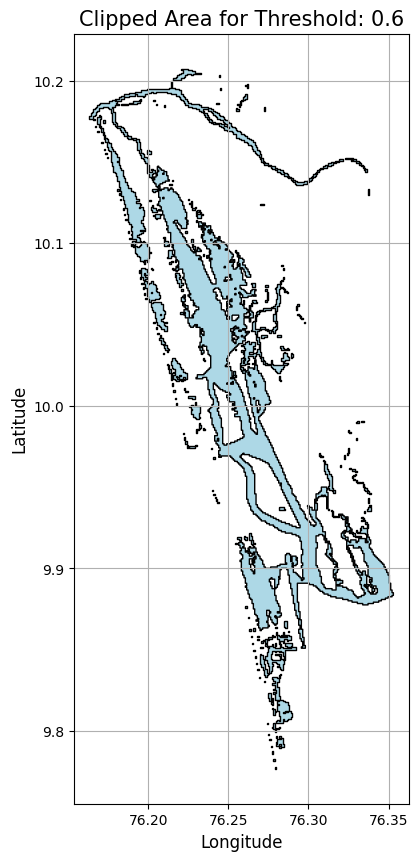

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_clipped_area(threshold):
    # Define the path to the clipped area shapefile based on the threshold
    clipped_shapefile_path = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"  # Adjust the path as needed

    # Load the clipped area shapefile
    clipped_gdf = gpd.read_file(clipped_shapefile_path)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))  # Set the figure size

    # Plot the clipped features
    clipped_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

    # Set plot title and labels
    ax.set_title(f'Clipped Area for Threshold: {threshold}', fontsize=15)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Show grid
    ax.grid(True)

    # Show the plot
    plt.show()

# Example usage
thresholds = [0.60]  # Define your thresholds
for threshold in thresholds:
    plot_clipped_area(threshold)

In [ ]:
Building extraction

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

def convert_csv_to_shapefile(csv_file, shp_file):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Convert the WKT geometry column to Shapely geometries
    df['geometry'] = df['geometry'].apply(wkt.loads)

    # Create a GeoDataFrame with polygon geometries
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    # Save the GeoDataFrame to a shapefile
    gdf.to_file(shp_file)

    return None
convert_csv_to_shapefile("/content/drive/MyDrive/colab files/coastal_panchayats_build.csv","/content/drive/MyDrive/Coastal_panchayats/Buildings/coastalpanch_build.shp")

<ipython-input-3-e4d5bc9b1233>:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shp_file)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'area_in_meters' to 'area_in_me'
  ogr_write(
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'full_plus_code' to 'full_plus_'
  ogr_write(


In [ ]:
import osgeo.ogr as ogr
from tabulate import tabulate

# # Define the output shapefile path for shp1 based on the threshold
# thresholds = [15]
# # for threshold in thresholds:
# #     output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

#     # Open the shapefiles
# shapefile1 = ogr.Open('/content/drive/MyDrive/Lowerbasin/lower_build.shp')  # Use the output_shp variable directly
# shapefile2 = ogr.Open('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')

    # Get the layersimport osgeo.ogr as ogr
from tabulate import tabulate

# Open the shapefiles
shapefile1 = ogr.Open('/content/drive/MyDrive/Coastal_panchayats/Buildings/coastalpanch_build.shp')
shapefile2 = ogr.Open('/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp')

# Get the layers
layer1 = shapefile1.GetLayer()
layer2 = shapefile2.GetLayer()

# Create a spatial index for layer 1
shapefile1.ExecuteSQL('CREATE SPATIAL INDEX ON coastal_buildings') # Replace 'coastal_buildings' with the actual layer name if it's different

# Create a list to store the results
results = []

# Iterate over the polygons in shapefile 2
for i, feature2 in enumerate(layer2):
    geom2 = feature2.GetGeometryRef()
    count = 0

    # Create an envelope geometry for the current feature in layer2
    envelope = geom2.GetEnvelope()

    # Create a ring from the envelope coordinates
    ring = ogr.Geometry(ogr.wkbLinearRing)
    ring.AddPoint(envelope[0], envelope[2])  # Lower left
    ring.AddPoint(envelope[1], envelope[2])  # Lower right
    ring.AddPoint(envelope[1], envelope[3])  # Upper right
    ring.AddPoint(envelope[0], envelope[3])  # Upper left
    ring.AddPoint(envelope[0], envelope[2])  # Close the ring

    # Create a polygon geometry from the ring
    polygon = ogr.Geometry(ogr.wkbPolygon)
    polygon.AddGeometry(ring)

    # Get features from layer1 that intersect with the polygon
    layer1.SetSpatialFilter(polygon)

    polygon_name = feature2.GetField("Name")
    # print(polygon_name, geom2)

    # Iterate over the features in layer1 that intersect with the polygon
    for feature1 in layer1:
        geom1 = feature1.GetGeometryRef()
        if geom2.Contains(geom1):
            count += 1

    # Append the result to the list
    results.append([i, polygon_name, count])

    # Reset spatial filter for the next feature in layer2
    layer1.SetSpatialFilter(None)

# Print the results as a table
print(tabulate(results, headers=["Index", "Polygon Name", "Count"], tablefmt="orgtbl"))
layer1 = shapefile1.GetLayer()
layer2 = shapefile2.GetLayer()

    # Create a list to store the results
results = []

    # Iterate over the polygons in shapefile 2
for i, feature2 in enumerate(layer2):
        geom2 = feature2.GetGeometryRef()
        count = 0

        # Create an envelope geometry for the current feature in layer2
        envelope = geom2.GetEnvelope()

        # Create a ring from the envelope coordinates
        ring = ogr.Geometry(ogr.wkbLinearRing)
        ring.AddPoint(envelope[0], envelope[2])  # Lower left
        ring.AddPoint(envelope[1], envelope[2])  # Lower right
        ring.AddPoint(envelope[1], envelope[3])  # Upper right
        ring.AddPoint(envelope[0], envelope[3])  # Upper left
        ring.AddPoint(envelope[0], envelope[2])  # Close the ring

        # Create a polygon geometry from the ring
        polygon = ogr.Geometry(ogr.wkbPolygon)
        polygon.AddGeometry(ring)

        # Get features from layer1 that intersect with the polygon
        layer1.SetSpatialFilter(polygon)

        polygon_name = feature2.GetField("Name")  # Adjust if necessary

        # Iterate over the features in layer1 that intersect with the polygon
        for feature1 in layer1:
            geom1 = feature1.GetGeometryRef()
            if geom2.Contains(geom1):
                count += 1

        # Append the result to the list
        results.append([i, polygon_name, count])

        # Reset spatial filter for the next feature in layer2
        layer1.SetSpatialFilter(None)

    # Print the results as a table
print(tabulate(results, headers=["Index", "Polygon Name", "Count"], tablefmt="orgtbl"))

|   Index | Polygon Name    |   Count |
|---------+-----------------+---------|
|       0 | Kochi           |  237382 |
|       1 | Karumalloor     |   17886 |
|       2 | Puthenvelikkara |   12501 |
|       3 | Chendamangalam  |   13566 |
|       4 | Paravur         |   18493 |
|       5 | Chittattukara   |    9240 |
|       6 | Pallippuram     |   21798 |
|       7 | Kottuvally      |   25700 |
|       8 | Kuzhuppilly     |    5693 |
|       9 | Edavanakad      |   10275 |
|      10 | Nayarambalam    |    9999 |
|      11 | Ezhikkara       |    9615 |
|      12 | Njarackal       |   10809 |
|      13 | Elamkunnapuzha  |   22869 |
|      14 | Mulavukadu      |    9555 |
|      15 | Kadamakkudy     |   12128 |
|      16 | Cherannalloor   |    7689 |
|      17 | Varapuzha       |   14470 |
|      18 | Vadakkekkara    |   14186 |
|      19 | Maradu          |   20384 |
|      20 | Kumbalam        |   13586 |
|      21 | Chellanam       |   17724 |
|      22 | Kumbalanghy     |   11343 |


To count buildings

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import os

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

def process_buildings_within_elevation_and_boundaries(threshold, elevation_shp_path, buildings_shp_path, boundaries_shapefile_path):
    try:
        # Load the elevation shapefile (at or below threshold)
        elevation_shp = gpd.read_file(elevation_shp_path)

        # Load the buildings shapefile
        buildings_shp = gpd.read_file(buildings_shp_path)

        # Perform the intersection operation to clip the buildings
        clipped_buildings = gpd.sjoin(buildings_shp, elevation_shp, predicate='within')

        # Save the clipped buildings to a new shapefile
        clipped_buildings_path = f'/content/drive/MyDrive/Coastal_panchayats/Buildings/{threshold}_coastal_building.shp'
        clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')

        # Count buildings within boundaries
        count_buildings_within_boundaries(clipped_buildings_path, boundaries_shapefile_path)

    except Exception as e:
        print(f"Error processing threshold {threshold}: {e}")

def count_buildings_within_boundaries(clipped_buildings_path, boundaries_shapefile_path):
    try:
        # Load the clipped buildings shapefile
        clipped_buildings = gpd.read_file(clipped_buildings_path)

        # Load the boundaries shapefile
        boundaries = gpd.read_file(boundaries_shapefile_path)

        # Prepare a list to store results
        results = []

        # Iterate over each polygon in the boundaries shapefile
        for index, boundary in boundaries.iterrows():
            polygon = boundary.geometry
            polygon_name = boundary['name']  # Adjust if necessary to match the actual column name

            # Count buildings that intersect with the polygon
            count = clipped_buildings[clipped_buildings.geometry.within(polygon)].shape[0]

            # Append the result to the list
            results.append([index, polygon_name, count])

        # Create a DataFrame from the results
        results_df = pd.DataFrame(results, columns=["Index", "Polygon Name", "Buildings"])

        # Print the results as a table
        print(tabulate(results, headers=["Index", "Polygon Name", "Buildings"], tablefmt="orgtbl"))

        # Define the output CSV file path
        output_csv_path = f"/content/drive/MyDrive/Coastal_panchayats/compiled_csv/{threshold}_coastal_compiling.csv"

        # Save the results to a CSV file
        results_df.to_csv(output_csv_path, index=False)

        print(f"Results saved to: {output_csv_path}")

    except Exception as e:
        print(f"Error counting buildings within boundaries: {e}")



In [ ]:
# Define thresholds and file paths
thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
              0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
              1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
              1.50]

buildings_shp_path = '/content/drive/MyDrive/Coastal_panchayats/Buildings/coastalpanch_build.shp'  # Adjust the path as necessary
boundaries_shapefile_path = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'  # Adjust the path as necessary

# Loop through each threshold
for threshold in thresholds:
    print(f'Threshold Running: {threshold}')
    elevation_shp_path = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"

    # Call the processing function
    process_buildings_within_elevation_and_boundaries(threshold, elevation_shp_path, buildings_shp_path, boundaries_shapefile_path)

Threshold Running: 0.0


<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1592 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         241 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         390 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         193 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1592 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         241 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         392 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         193 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1592 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         241 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         392 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         193 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1592 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         241 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         392 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         193 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1592 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         241 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         392 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         193 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1605 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         241 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         402 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         193 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1605 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         241 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         402 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         193 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1605 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          38 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         248 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         407 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         196 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1605 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          41 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         248 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         409 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         196 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1605 |
|       1 | Karumalloor     |           0 |
|       2 | Puthenvelikkara |           1 |
|       3 | Chendamangalam  |           0 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |           0 |
|       6 | Pallippuram     |         244 |
|       7 | Kottuvally      |          41 |
|       8 | Kuzhuppilly     |         126 |
|       9 | Edavanakad      |         141 |
|      10 | Nayarambalam    |         148 |
|      11 | Ezhikkara       |         248 |
|      12 | Njarackal       |         101 |
|      13 | Elamkunnapuzha  |         411 |
|      14 | Mulavukadu      |         334 |
|      15 | Kadamakkudy     |         197 |
|      16 | Cherannalloor   |           0 |
|      17 | Varapuzha       |          15 |
|      18 | Vadakkekkara    |           0 |
|      19 | Maradu          |         128 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1802 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          69 |
|       3 | Chendamangalam  |          79 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          55 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         154 |
|      10 | Nayarambalam    |         175 |
|      11 | Ezhikkara       |         293 |
|      12 | Njarackal       |         139 |
|      13 | Elamkunnapuzha  |         485 |
|      14 | Mulavukadu      |         383 |
|      15 | Kadamakkudy     |         455 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         170 |
|      18 | Vadakkekkara    |         191 |
|      19 | Maradu          |         141 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1802 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          69 |
|       3 | Chendamangalam  |          79 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          55 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         169 |
|      10 | Nayarambalam    |         175 |
|      11 | Ezhikkara       |         293 |
|      12 | Njarackal       |         139 |
|      13 | Elamkunnapuzha  |         493 |
|      14 | Mulavukadu      |         383 |
|      15 | Kadamakkudy     |         458 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         170 |
|      18 | Vadakkekkara    |         191 |
|      19 | Maradu          |         141 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1812 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          69 |
|       3 | Chendamangalam  |          79 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          56 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         185 |
|      10 | Nayarambalam    |         177 |
|      11 | Ezhikkara       |         293 |
|      12 | Njarackal       |         139 |
|      13 | Elamkunnapuzha  |         523 |
|      14 | Mulavukadu      |         383 |
|      15 | Kadamakkudy     |         469 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         170 |
|      18 | Vadakkekkara    |         191 |
|      19 | Maradu          |         142 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1842 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          69 |
|       3 | Chendamangalam  |          79 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          56 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         194 |
|      10 | Nayarambalam    |         177 |
|      11 | Ezhikkara       |         294 |
|      12 | Njarackal       |         139 |
|      13 | Elamkunnapuzha  |         534 |
|      14 | Mulavukadu      |         383 |
|      15 | Kadamakkudy     |         482 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         170 |
|      18 | Vadakkekkara    |         191 |
|      19 | Maradu          |         142 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1873 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          69 |
|       3 | Chendamangalam  |          87 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          57 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         226 |
|      10 | Nayarambalam    |         177 |
|      11 | Ezhikkara       |         297 |
|      12 | Njarackal       |         139 |
|      13 | Elamkunnapuzha  |         590 |
|      14 | Mulavukadu      |         383 |
|      15 | Kadamakkudy     |         492 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         170 |
|      18 | Vadakkekkara    |         191 |
|      19 | Maradu          |         144 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1878 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          69 |
|       3 | Chendamangalam  |          87 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          57 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         232 |
|      10 | Nayarambalam    |         182 |
|      11 | Ezhikkara       |         299 |
|      12 | Njarackal       |         147 |
|      13 | Elamkunnapuzha  |         633 |
|      14 | Mulavukadu      |         383 |
|      15 | Kadamakkudy     |         508 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         175 |
|      18 | Vadakkekkara    |         191 |
|      19 | Maradu          |         153 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1906 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          70 |
|       3 | Chendamangalam  |          87 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          59 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         266 |
|      10 | Nayarambalam    |         182 |
|      11 | Ezhikkara       |         304 |
|      12 | Njarackal       |         164 |
|      13 | Elamkunnapuzha  |         751 |
|      14 | Mulavukadu      |         383 |
|      15 | Kadamakkudy     |         508 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         175 |
|      18 | Vadakkekkara    |         197 |
|      19 | Maradu          |         153 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1919 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          70 |
|       3 | Chendamangalam  |          92 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          59 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         271 |
|      10 | Nayarambalam    |         190 |
|      11 | Ezhikkara       |         315 |
|      12 | Njarackal       |         168 |
|      13 | Elamkunnapuzha  |         841 |
|      14 | Mulavukadu      |         385 |
|      15 | Kadamakkudy     |         508 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         181 |
|      18 | Vadakkekkara    |         197 |
|      19 | Maradu          |         153 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        1981 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          70 |
|       3 | Chendamangalam  |          92 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          63 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         287 |
|      10 | Nayarambalam    |         190 |
|      11 | Ezhikkara       |         315 |
|      12 | Njarackal       |         178 |
|      13 | Elamkunnapuzha  |         938 |
|      14 | Mulavukadu      |         394 |
|      15 | Kadamakkudy     |         519 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         185 |
|      18 | Vadakkekkara    |         197 |
|      19 | Maradu          |         160 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        2003 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          70 |
|       3 | Chendamangalam  |          92 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          14 |
|       6 | Pallippuram     |         376 |
|       7 | Kottuvally      |          64 |
|       8 | Kuzhuppilly     |         158 |
|       9 | Edavanakad      |         315 |
|      10 | Nayarambalam    |         201 |
|      11 | Ezhikkara       |         322 |
|      12 | Njarackal       |         194 |
|      13 | Elamkunnapuzha  |        1051 |
|      14 | Mulavukadu      |         399 |
|      15 | Kadamakkudy     |         521 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         185 |
|      18 | Vadakkekkara    |         197 |
|      19 | Maradu          |         163 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        2084 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          83 |
|       3 | Chendamangalam  |         115 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          43 |
|       6 | Pallippuram     |         400 |
|       7 | Kottuvally      |         120 |
|       8 | Kuzhuppilly     |         199 |
|       9 | Edavanakad      |         328 |
|      10 | Nayarambalam    |         232 |
|      11 | Ezhikkara       |         347 |
|      12 | Njarackal       |         212 |
|      13 | Elamkunnapuzha  |        1300 |
|      14 | Mulavukadu      |         459 |
|      15 | Kadamakkudy     |         555 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         195 |
|      18 | Vadakkekkara    |         204 |
|      19 | Maradu          |         196 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        2230 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          84 |
|       3 | Chendamangalam  |         131 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          46 |
|       6 | Pallippuram     |         417 |
|       7 | Kottuvally      |         133 |
|       8 | Kuzhuppilly     |         211 |
|       9 | Edavanakad      |         337 |
|      10 | Nayarambalam    |         241 |
|      11 | Ezhikkara       |         349 |
|      12 | Njarackal       |         250 |
|      13 | Elamkunnapuzha  |        1495 |
|      14 | Mulavukadu      |         487 |
|      15 | Kadamakkudy     |         573 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         197 |
|      18 | Vadakkekkara    |         219 |
|      19 | Maradu          |         211 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        2296 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          84 |
|       3 | Chendamangalam  |         153 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          46 |
|       6 | Pallippuram     |         417 |
|       7 | Kottuvally      |         140 |
|       8 | Kuzhuppilly     |         211 |
|       9 | Edavanakad      |         371 |
|      10 | Nayarambalam    |         258 |
|      11 | Ezhikkara       |         353 |
|      12 | Njarackal       |         293 |
|      13 | Elamkunnapuzha  |        1642 |
|      14 | Mulavukadu      |         514 |
|      15 | Kadamakkudy     |         620 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         210 |
|      18 | Vadakkekkara    |         224 |
|      19 | Maradu          |         279 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        2563 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          84 |
|       3 | Chendamangalam  |         157 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          46 |
|       6 | Pallippuram     |         417 |
|       7 | Kottuvally      |         152 |
|       8 | Kuzhuppilly     |         211 |
|       9 | Edavanakad      |         399 |
|      10 | Nayarambalam    |         288 |
|      11 | Ezhikkara       |         358 |
|      12 | Njarackal       |         337 |
|      13 | Elamkunnapuzha  |        1843 |
|      14 | Mulavukadu      |         569 |
|      15 | Kadamakkudy     |         655 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         216 |
|      18 | Vadakkekkara    |         228 |
|      19 | Maradu          |         346 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        2789 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          86 |
|       3 | Chendamangalam  |         157 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          46 |
|       6 | Pallippuram     |         417 |
|       7 | Kottuvally      |         157 |
|       8 | Kuzhuppilly     |         211 |
|       9 | Edavanakad      |         441 |
|      10 | Nayarambalam    |         317 |
|      11 | Ezhikkara       |         362 |
|      12 | Njarackal       |         389 |
|      13 | Elamkunnapuzha  |        2002 |
|      14 | Mulavukadu      |         593 |
|      15 | Kadamakkudy     |         739 |
|      16 | Cherannalloor   |          32 |
|      17 | Varapuzha       |         217 |
|      18 | Vadakkekkara    |         229 |
|      19 | Maradu          |         416 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        3051 |
|       1 | Karumalloor     |          21 |
|       2 | Puthenvelikkara |          86 |
|       3 | Chendamangalam  |         157 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          51 |
|       6 | Pallippuram     |         421 |
|       7 | Kottuvally      |         159 |
|       8 | Kuzhuppilly     |         214 |
|       9 | Edavanakad      |         490 |
|      10 | Nayarambalam    |         351 |
|      11 | Ezhikkara       |         384 |
|      12 | Njarackal       |         436 |
|      13 | Elamkunnapuzha  |        2203 |
|      14 | Mulavukadu      |         660 |
|      15 | Kadamakkudy     |         805 |
|      16 | Cherannalloor   |          35 |
|      17 | Varapuzha       |         230 |
|      18 | Vadakkekkara    |         232 |
|      19 | Maradu          |         489 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        3274 |
|       1 | Karumalloor     |          22 |
|       2 | Puthenvelikkara |          87 |
|       3 | Chendamangalam  |         168 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          65 |
|       6 | Pallippuram     |         427 |
|       7 | Kottuvally      |         162 |
|       8 | Kuzhuppilly     |         225 |
|       9 | Edavanakad      |         522 |
|      10 | Nayarambalam    |         389 |
|      11 | Ezhikkara       |         404 |
|      12 | Njarackal       |         447 |
|      13 | Elamkunnapuzha  |        2398 |
|      14 | Mulavukadu      |         771 |
|      15 | Kadamakkudy     |         922 |
|      16 | Cherannalloor   |          48 |
|      17 | Varapuzha       |         241 |
|      18 | Vadakkekkara    |         236 |
|      19 | Maradu          |         627 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        3664 |
|       1 | Karumalloor     |          22 |
|       2 | Puthenvelikkara |         104 |
|       3 | Chendamangalam  |         171 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          70 |
|       6 | Pallippuram     |         452 |
|       7 | Kottuvally      |         169 |
|       8 | Kuzhuppilly     |         241 |
|       9 | Edavanakad      |         609 |
|      10 | Nayarambalam    |         418 |
|      11 | Ezhikkara       |         429 |
|      12 | Njarackal       |         483 |
|      13 | Elamkunnapuzha  |        2583 |
|      14 | Mulavukadu      |         825 |
|      15 | Kadamakkudy     |        1029 |
|      16 | Cherannalloor   |          54 |
|      17 | Varapuzha       |         265 |
|      18 | Vadakkekkara    |         249 |
|      19 | Maradu          |         832 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        4201 |
|       1 | Karumalloor     |          26 |
|       2 | Puthenvelikkara |         108 |
|       3 | Chendamangalam  |         171 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |          80 |
|       6 | Pallippuram     |         471 |
|       7 | Kottuvally      |         173 |
|       8 | Kuzhuppilly     |         263 |
|       9 | Edavanakad      |         717 |
|      10 | Nayarambalam    |         480 |
|      11 | Ezhikkara       |         465 |
|      12 | Njarackal       |         631 |
|      13 | Elamkunnapuzha  |        2900 |
|      14 | Mulavukadu      |         901 |
|      15 | Kadamakkudy     |        1217 |
|      16 | Cherannalloor   |          57 |
|      17 | Varapuzha       |         290 |
|      18 | Vadakkekkara    |         262 |
|      19 | Maradu          |         943 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        4540 |
|       1 | Karumalloor     |          36 |
|       2 | Puthenvelikkara |         117 |
|       3 | Chendamangalam  |         186 |
|       4 | Paravur         |           0 |
|       5 | Chittattukara   |         113 |
|       6 | Pallippuram     |         497 |
|       7 | Kottuvally      |         181 |
|       8 | Kuzhuppilly     |         263 |
|       9 | Edavanakad      |         811 |
|      10 | Nayarambalam    |         594 |
|      11 | Ezhikkara       |         532 |
|      12 | Njarackal       |         747 |
|      13 | Elamkunnapuzha  |        3201 |
|      14 | Mulavukadu      |         991 |
|      15 | Kadamakkudy     |        1460 |
|      16 | Cherannalloor   |          61 |
|      17 | Varapuzha       |         329 |
|      18 | Vadakkekkara    |         262 |
|      19 | Maradu          |        1201 |
|      20 | Kumbalam        |   

<ipython-input-6-819c5a32a3a4>:24: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_buildings.to_file(clipped_buildings_path, driver='ESRI Shapefile')
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


|   Index | Polygon Name    |   Buildings |
|---------+-----------------+-------------|
|       0 | Kochi           |        5576 |
|       1 | Karumalloor     |          69 |
|       2 | Puthenvelikkara |         133 |
|       3 | Chendamangalam  |         206 |
|       4 | Paravur         |           1 |
|       5 | Chittattukara   |         116 |
|       6 | Pallippuram     |         521 |
|       7 | Kottuvally      |         246 |
|       8 | Kuzhuppilly     |         282 |
|       9 | Edavanakad      |         927 |
|      10 | Nayarambalam    |         630 |
|      11 | Ezhikkara       |         607 |
|      12 | Njarackal       |         856 |
|      13 | Elamkunnapuzha  |        3803 |
|      14 | Mulavukadu      |        1144 |
|      15 | Kadamakkudy     |        1701 |
|      16 | Cherannalloor   |          82 |
|      17 | Varapuzha       |         364 |
|      18 | Vadakkekkara    |         285 |
|      19 | Maradu          |        1426 |
|      20 | Kumbalam        |   

**roads** extraction and csv converted to shp

In [ ]:

!pip install GOSTnets # Make sure to install in the notebook's kernel
import geopandas as gpd
import os
import GOSTnets as gn # After restarting runtime, import should work

from GOSTnets.load_osm import OSM_to_network

import os

# Set the path to your working folder
pth = "//content/drive/MyDrive/Lowerbasin"  # change this path to your working folder
fil = r"southern-zone-latest.osm.pbf"  # specify your .osm.pbf file

# Construct the full file path
f = os.path.join(pth, fil)

# Now 'f' contains the complete path to the .osm.pbf file

# check if the file exists, raise an exception if it does not
if os.path.isfile(f):
    print("File found.")
else:
    raise Exception("File not found.")
# print the file path
print(f)

# convert the .osm.pbf file to a GOSTnets object
coast = OSM_to_network(f)

# show the doc-string for the OSM_to_network object
# ?coast

# display the first 5 rows of the extracted dataframe of the roads network
coast.roads_raw.head()

# show the different road types and counts
coast.roads_raw.infra_type.value_counts()

accepted_road_types = [
    "residential",
    "unclassified",
    "track",
    "service",
    "tertiary",
    "road",
    "secondary",
    "primary",
    "trunk",
    "primary_link",
    "trunk_link",
    "tertiary_link",
    "secondary_link",
]

# filter roads
coast.filterRoads(acceptedRoads=accepted_road_types)

coast.roads_raw.infra_type.value_counts()

os.path.join('test/file', 'build', 'file.shp')

# read the shapefile for the clip area
# clip_shp = gpd.read_file(os.path.join(pth, "lower_basin_lsg_panchayat.shp"))
clip_shp = gpd.read_file("/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp")
clip_shp = clip_shp.to_crs("epsg:4326")
clip_shp_obj = clip_shp.unary_union

# visualize the clip area
clip_shp.plot()

# this is the geometry object (shapely) from clip_shp
clip_shp_obj

# intersects is a Shapely function that returns True if the boundary or interior of the object intersect in any way with those of the other
coast.roads_raw.geometry.intersects(clip_shp_obj).value_counts()

coast.roads_raw = coast.roads_raw.loc[
    coast.roads_raw.geometry.intersects(clip_shp_obj) == True  # noqa: E712
]

# reprint the intersects value counts (should only be True now)
coast.roads_raw.geometry.intersects(clip_shp_obj).value_counts()

# Assign the filtered roads_raw to roadsGPD
coast.roadsGPD = coast.roads_raw

# view the first 5 rows of the newly created roads GeoDataFrame
coast.roadsGPD.head()

# generate the roads GeoDataFrame, may take a few minutes
coast.generateRoadsGDF(verbose=False)

gdf = coast.generateRoadsGDF(verbose=False)

# view the first 5 rows of the newly created roads GeoDataFrame
coast.roadsGPD.head()

coast.roadsGPD.to_csv(os.path.join(pth, "roads.csv"))

# Set the 'Wkt' column as the active geometry column before plotting
coast.roadsGPD = coast.roadsGPD.set_geometry('Wkt')

# Now you should be able to plot the GeoDataFrame
coast.roadsGPD.plot()

# GeoDataFrame into a graph object
coast.initialReadIn()

gn.save?



# import pickle
# # G = nx.path_graph(4)

# with open('road_unclean', 'wb') as f:
#     pickle.dump(coast.network, f, pickle.HIGHEST_PROTOCOL)
#     # gn.save(coast.network, "road_unclean", os.path.join(pth),pickle=True)

# import networkx as nx
# print(nx.__version__)

# convert to shp
import pandas as pd
import geopandas as gpd

def convert_csv_to_shapefile(csv_file, shp_file):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(csv_file)

    # Create a geometry column from the 'wkt' column
    # Applying the function to the entire 'Wkt' column to create a GeoSeries
    df['geometry'] = gpd.GeoSeries.from_wkt(df['Wkt'])
    # Creating a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

    # Write the GeoDataFrame to a Shapefile
    gdf.to_file(shp_file)

    return None

# Example usage
convert_csv_to_shapefile("/content/drive/MyDrive/Lowerbasin/roads_lower.csv",
                         "/content/drive/MyDrive/Lowerbasin/roadsntwrk_lower.shp")


full data

In [ ]:
import geopandas as gpd
import pandas as pd

# Load the clipped roads shapefile
clipped_roads = gpd.read_file('/content/drive/MyDrive/colab files/roadsntwrk_lower.shp')

# Load the boundary shapefile (replace with your actual boundary shapefile path)
boundary_shp = gpd.read_file('/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp')  # Adjust the path as necessary

# Reproject the clipped roads to 'EPSG:32643'
clipped_roads = clipped_roads.to_crs(epsg=32643)

# Reproject the boundary shapefile to 'EPSG:32643'
boundary_shp = boundary_shp.to_crs(epsg=32643)

# Initialize a list to store results
results = []

# Iterate through each polygon in the boundary shapefile
for index, polygon in boundary_shp.iterrows():
    # Filter the clipped roads that intersect with the current polygon
    roads_within_polygon = clipped_roads[clipped_roads.intersects(polygon.geometry)]

    # Sum the lengths of the filtered roads
    total_length = roads_within_polygon.length.sum()

    # Append the results to the list
    results.append({
        'Polygon Name': polygon['name'],  # Adjust if necessary
        'Sum of Length (km)': total_length / 1000  # Convert to kilometers
    })

# Create a summary DataFrame from the results
summary_table = pd.DataFrame(results)

# Print the summary table
print(summary_table.to_string(index=False))



   Polygon Name  Sum of Length (km)
          Kochi         1363.461664
    Karumalloor          143.636362
Puthenvelikkara          109.779546
 Chendamangalam          106.095947
        Paravur          116.805268
  Chittattukara           68.977973
    Pallippuram          135.053522
     Kottuvally          164.437195
    Kuzhuppilly           47.791810
     Edavanakad           80.420719
   Nayarambalam           73.700901
      Ezhikkara           58.156200
      Njarackal           64.145931
 Elamkunnapuzha          149.475543
     Mulavukadu           76.069677
    Kadamakkudy           91.325627
  Cherannalloor           49.879806
      Varapuzha           79.788274
   Vadakkekkara           94.589230
         Maradu          141.486122
       Kumbalam            3.762019
      Chellanam            9.208553
    Kumbalanghy            0.227480


thresholdwise

In [1]:
import geopandas as gpd
import pandas as pd
import os

def load_shapefile(file_path):
    """Load a shapefile and return a GeoDataFrame."""
    return gpd.read_file(file_path)

def clip_roads_to_elevation(road_shp, elevation_shp):
    """Clip the roads to the given elevation shapefile."""
    return gpd.overlay(road_shp, elevation_shp, how='intersection')

def calculate_road_lengths_within_boundaries(clipped_roads, boundary_shp):
    """Calculate the total lengths of roads within each boundary polygon."""
    results = []
    for index, polygon in boundary_shp.iterrows():
        roads_within_polygon = clipped_roads[clipped_roads.intersects(polygon.geometry)]
        total_length = roads_within_polygon.length.sum()
        results.append({
            'Polygon Name': polygon['name'],  # Adjust if necessary
            'Sum of Length (km)': round(total_length / 1000, 2)  # Convert to kilometers
        })
    return pd.DataFrame(results)

def update_csv_with_results(summary_table, csv_path):
    """Update the CSV file with the new results."""
    if os.path.exists(csv_path):
        existing_df = pd.read_csv(csv_path)
    else:
        existing_df = pd.DataFrame(columns=['Polygon Name', 'Roads (km)'])

    for index, row in summary_table.iterrows():
        polygon_name = row['Polygon Name']
        total_length = row['Sum of Length (km)']
        existing_df.loc[existing_df['Polygon Name'] == polygon_name, 'Roads (km)'] = total_length

    existing_df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")

def process_and_analyze_roads(thresholds, elevation_shp_path, road_shp_path, boundary_shp_path, csv_path_template):
    for threshold in thresholds:
        output_shp = elevation_shp_path.format(threshold=threshold)

        # Load the elevation shapefile (at or below threshold)
        elevation_shp = load_shapefile(output_shp)

        # Load the road shapefile
        road_shp = load_shapefile(road_shp_path)

        # Clip the roads to the elevation area
        clipped_roads = clip_roads_to_elevation(road_shp, elevation_shp)

        # Save the clipped roads to a new shapefile
        clipped_roads_path = f'/content/drive/MyDrive/Coastal_panchayats/Roads/coastal_roads{threshold}.shp'
        clipped_roads.to_file(clipped_roads_path, driver='ESRI Shapefile')

        # Load the boundary shapefile
        boundary_shp = load_shapefile(boundary_shp_path)

        # Reproject the clipped roads and boundary shapefile to 'EPSG:32643'
        clipped_roads = clipped_roads.to_crs(epsg=32643)
        boundary_shp = boundary_shp.to_crs(epsg=32643)

        # Calculate road lengths within boundaries
        summary_table = calculate_road_lengths_within_boundaries(clipped_roads, boundary_shp)

        # Print the summary table
        print(summary_table.to_string(index=False))

        # Define the CSV path for the current threshold
        csv_path = csv_path_template.format(threshold=threshold)

        # Update the CSV with the results
        update_csv_with_results(summary_table, csv_path)

# # Example usage
# thresholds = [0.0, 2.75]  # Define your thresholds
# elevation_shp_path = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"
# road_shp_path = '/content/drive/MyDrive/Lowerbasin/roadsntwrk_lower.shp'
# boundary_shp_path = '/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp'
# csv_path_template = '/content/drive/MyDrive/Lowerbasin/csv_lower/{threshold}_building_counts.csv'

# # Run the function
# process_and_analyze_roads(thresholds, elevation_shp_path, road_shp_path, boundary_shp_path, csv_path_template)

In [4]:
# # Define thresholds and file paths
# thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
#               0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
#               1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
#               1.50]
# thresholds = [0.00, 1.25]
thresholds = [ 1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
              1.50]

road_shp_path = '/content/drive/MyDrive/colab files/roads.shp'  # Adjust the path as necessary
boundary_shp_path = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'  # Adjust the path as necessary

for threshold in thresholds:
    print(f'Threshold Running: {threshold}')
    elevation_shp_path = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"
    csv_path_template = f"/content/drive/MyDrive/Coastal_panchayats/compiled_csv/{threshold}_coastal_compiling.csv"

    # Call the processing function
    process_and_analyze_roads([threshold], elevation_shp_path, road_shp_path, boundary_shp_path, csv_path_template)

Threshold Running: 1.0
   Polygon Name  Sum of Length (km)
          Kochi               18.40
    Karumalloor                0.43
Puthenvelikkara                2.26
 Chendamangalam                1.98
        Paravur                0.00
  Chittattukara                1.15
    Pallippuram                5.38
     Kottuvally                1.60
    Kuzhuppilly                4.10
     Edavanakad                6.02
   Nayarambalam                4.22
      Ezhikkara                4.39
      Njarackal                2.63
 Elamkunnapuzha               13.86
     Mulavukadu                8.27
    Kadamakkudy                9.06
  Cherannalloor                0.63
      Varapuzha                2.98
   Vadakkekkara                1.55
         Maradu                1.74
       Kumbalam                5.45
      Chellanam               15.49
    Kumbalanghy                3.99
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/1.0_coastal_compiling.csv
Threshold Runn

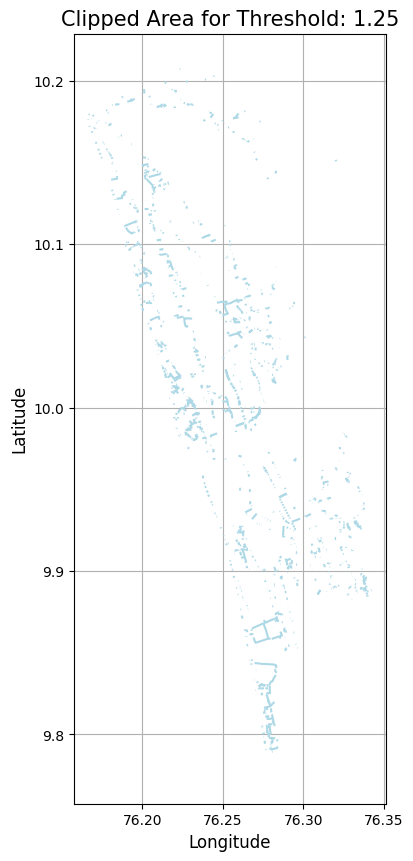

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_clipped_area(threshold):
    # Define the path to the clipped area shapefile based on the threshold
    clipped_shapefile_path = f"/content/drive/MyDrive/Coastal_panchayats/Roads/coastal_roads{threshold}.shp"  # Adjust the path as needed

    # Load the clipped area shapefile
    clipped_gdf = gpd.read_file(clipped_shapefile_path)

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))  # Set the figure size

    # Plot the clipped features
    clipped_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

    # Set plot title and labels
    ax.set_title(f'Clipped Area for Threshold: {threshold}', fontsize=15)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Show grid
    ax.grid(True)

    # Show the plot
    plt.show()

# Example usage
thresholds = [1.25]  # Define your thresholds
for threshold in thresholds:
    plot_clipped_area(threshold)

LULC Area calculation

In [17]:
# Total

import geopandas as gpd

# Load the road shapefile
lulc_gdf = gpd.read_file('/content/drive/MyDrive/Coastal_panchayats/agriculture_lulc_coastal1.shp')

# Load the boundary shapefile
boundary_gdf = gpd.read_file('/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp')

# Define a projected CRS
projected_crs = 'EPSG:32643'

# Create a table to store the results
results = []

# Loop through each polygon in the boundary shapefile
for i, polygon in boundary_gdf.iterrows():
    # Clip the road shapefile within the current polygon
    clipped_lulc = gpd.clip(lulc_gdf, polygon.geometry)

    # Re-project the clipped roads to the projected CRS
    clipped_lulc_projected = clipped_lulc.to_crs(projected_crs)

    # Calculate the sum of length of linestring within the polygon
    total_length = clipped_lulc_projected.length.sum()

    # Append the results to the table
    results.append({
        'Polygon Name': polygon['name'],
        'Sum of Length': total_length/10**4
    })

# Print the table
print("Polygon Name\tSum of Length")
for result in results:
    print(f"{result['Polygon Name']}\t{result['Sum of Length']:.2f}")

Polygon Name	Sum of Length
Kochi	5.04
Karumalloor	10.62
Puthenvelikkara	12.49
Chendamangalam	0.46
Paravur	0.00
Chittattukara	0.58
Pallippuram	1.34
Kottuvally	5.07
Kuzhuppilly	2.81
Edavanakad	3.85
Nayarambalam	5.01
Ezhikkara	6.30
Njarackal	3.61
Elamkunnapuzha	5.14
Mulavukadu	4.33
Kadamakkudy	7.37
Cherannalloor	0.96
Varapuzha	2.81
Vadakkekkara	0.49
Maradu	2.27
Kumbalam	4.56
Chellanam	6.11
Kumbalanghy	2.63


In [23]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import os

# Define the function to process and analyze LULC
def process_and_analyze_lulc(threshold, elevation_shp_path, lulc_shp_path, boundary_shp_path, csv_path_template):
    output_shp = elevation_shp_path

    # Load the elevation shapefile (at or below threshold)
    elevation_shp = gpd.read_file(output_shp)

    # Load the LULC shapefile
    lulc_shp = gpd.read_file(lulc_shp_path)

    # Perform the intersection operation to clip the LULC
    clipped_lulc = gpd.overlay(lulc_shp, elevation_shp, how='intersection')

    # Save the clipped LULC to a new shapefile
    clipped_lulc_path = f'/content/drive/MyDrive/Coastal_panchayats/Agriculture/coastal_{threshold}lulc.shp'
    clipped_lulc.to_file(clipped_lulc_path, driver='ESRI Shapefile')

    # Load the boundary shapefile
    boundary_shp = gpd.read_file(boundary_shp_path)

    # Reproject the clipped LULC and boundary shapefile to 'EPSG:32643'
    clipped_lulc = clipped_lulc.to_crs(epsg=32643)
    boundary_shp = boundary_shp.to_crs(epsg=32643)

    # Initialize a list to store results
    results = []

    # Iterate through each polygon in the boundary shapefile
    for index, polygon in boundary_shp.iterrows():
        # Filter the clipped LULC that intersects with the current polygon
        lulc_within_polygon = clipped_lulc[clipped_lulc.intersects(polygon.geometry)]

        # Calculate the area of the filtered LULC
        total_area = lulc_within_polygon.area.sum() / 10**6  # Convert to square kilometers

        # Append the results to the list
        results.append({
            'Polygon Name': polygon['name'],  # Adjust if necessary
            'Sum of Area (km²)': round(total_area, 2)  # Round to 2 decimal places
        })

    # Create a summary DataFrame from the results
    summary_table = pd.DataFrame(results)

    # Print the summary table
    print(f"Summary for threshold {threshold}:")
    print(summary_table.to_string(index=False))

    # Define the CSV path for the current threshold
    csv_path = csv_path_template.format(threshold=threshold)

    # Load existing CSV data or create a new DataFrame if it does not exist
    if os.path.exists(csv_path):
        existing_df = pd.read_csv(csv_path)
    else:
        existing_df = pd.DataFrame(columns=['Polygon Name', 'Agriculture (sq.km)'])  # Create a new DataFrame if the CSV does not exist

    # Update the 'LULC Area' column only if it's NaN
    for index, row in summary_table.iterrows():
        polygon_name = row['Polygon Name']
        total_area = row['Sum of Area (km²)']

        # Use .loc with a proper condition to update or append
        existing_df.loc[existing_df['Polygon Name'] == polygon_name, 'Agriculture (sq.km)'] = total_area

    # Save the updated DataFrame back to the CSV file
    existing_df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")



In [24]:
# Define the list of thresholds
thresholds = [0.00,1.25]
# thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
#               0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
#               1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
#               1.50]

# Define file paths
lulc_shp_path = '/content/drive/MyDrive/Coastal_panchayats/agriculture_lulc_coastal1.shp'  # Updated path for LULC shapefile
boundary_shp_path = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'  # Adjust the path as necessary

# Loop through each threshold
for threshold in thresholds:
    print(f'Threshold Running: {threshold}')
    elevation_shp_path = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"
    csv_path_template = f"/content/drive/MyDrive/Coastal_panchayats/compiled_csv/{threshold}_coastal_compiling.csv"

    # Call the processing function
    process_and_analyze_lulc(threshold, elevation_shp_path, lulc_shp_path, boundary_shp_path, csv_path_template)

Threshold Running: 1.25
Summary for threshold 1.25:
   Polygon Name  Sum of Area (km²)
          Kochi               2.13
    Karumalloor               0.18
Puthenvelikkara               1.48
 Chendamangalam               0.03
        Paravur               0.00
  Chittattukara               0.33
    Pallippuram               4.45
     Kottuvally               3.54
    Kuzhuppilly               2.70
     Edavanakad               3.01
   Nayarambalam               5.60
      Ezhikkara              10.86
      Njarackal               3.56
 Elamkunnapuzha               2.11
     Mulavukadu               2.30
    Kadamakkudy               5.82
  Cherannalloor               0.03
      Varapuzha               4.90
   Vadakkekkara               0.12
         Maradu               1.23
       Kumbalam               1.90
      Chellanam               7.21
    Kumbalanghy               2.18
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/1.25_coastal_compiling.csv


Lets add area

In [43]:
import geopandas as gpd
import pandas as pd
from tabulate import tabulate
import os

def process_and_analyze_elevation_area(threshold, output_shp, boundary_shp_path, csv_path):
    # Load the shapefile and boundary shapefile
    shp1_gdf = gpd.read_file(output_shp)
    boundary_gdf = gpd.read_file(boundary_shp_path)

    # Reproject both GeoDataFrames to EPSG:32643
    projected_crs = 'EPSG:32643'
    shp1_projected = shp1_gdf.to_crs(projected_crs)
    boundary_projected = boundary_gdf.to_crs(projected_crs)

    # Create a table to store the results
    results = []

    # Loop through each polygon in the boundary shapefile
    for i, polygon in boundary_projected.iterrows():
        # Clip the shp1 within the current polygon
        clipped_features = gpd.clip(shp1_projected, polygon.geometry)

        # Calculate the area of the clipped features in square kilometers
        clipped_area = round(clipped_features.area.sum() / 10**6, 2)  # Convert from m² to km²

        # Append the results to the table
        results.append({
            'Polygon Name': polygon['name'],  # Assuming 'name' is the field for polygon names
            'Area (sq.km)': clipped_area
        })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Print the results
    print(f"Results for threshold {threshold}:")
    print(tabulate(results_df[['Polygon Name', 'Area (sq.km)']], headers='keys', tablefmt='psql'))

    # Append or create the CSV file for the current threshold
    if os.path.exists(csv_path):
        # Load existing data
        existing_df = pd.read_csv(csv_path)

        # Update the existing DataFrame with new areas
        for index, row in results_df.iterrows():
            polygon_name = row['Polygon Name']
            area_value = row['Area (sq.km)']

            # Update the existing DataFrame if the polygon name exists
            if polygon_name in existing_df['Polygon Name'].values:
                existing_df.loc[existing_df['Polygon Name'] == polygon_name, 'Area (sq.km)'] = area_value
            else:
                # Append new results that are not already in the existing DataFrame
                existing_df = existing_df.append(row, ignore_index=True)
    else:
        # No existing data, use the results as is
        existing_df = results_df

    # Save the combined data back to the CSV
    existing_df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")


In [28]:
# Define the thresholds
thresholds = [0.00,1.25]
# thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
#               0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
#               1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
#               1.50]

# Define the path template for the CSV files

boundary_shp_path = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'  # Adjust the path as necessary

# Loop through each threshold
for threshold in thresholds:
    print(f'Threshold Running: {threshold}')
    elevation_shp = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"
    csv_path_template = f"/content/drive/MyDrive/Coastal_panchayats/compiled_csv/{threshold}_coastal_compiling.csv"
    process_and_analyze_elevation_area(threshold, elevation_shp, boundary_shp_path, csv_path_template)

Threshold Running: 0.0
Results for threshold 0.0:
+----+-----------------+----------------+
|    | Polygon Name    |   Area (sq.km) |
|----+-----------------+----------------|
|  0 | Kochi           |          19.72 |
|  1 | Karumalloor     |           0    |
|  2 | Puthenvelikkara |           0.14 |
|  3 | Chendamangalam  |           0    |
|  4 | Paravur         |           0    |
|  5 | Chittattukara   |           0.01 |
|  6 | Pallippuram     |           2.7  |
|  7 | Kottuvally      |           2.96 |
|  8 | Kuzhuppilly     |           2.77 |
|  9 | Edavanakad      |           3.15 |
| 10 | Nayarambalam    |           5.61 |
| 11 | Ezhikkara       |           9.86 |
| 12 | Njarackal       |           3.27 |
| 13 | Elamkunnapuzha  |           3.39 |
| 14 | Mulavukadu      |           7.36 |
| 15 | Kadamakkudy     |           4.75 |
| 16 | Cherannalloor   |           0    |
| 17 | Varapuzha       |           1.54 |
| 18 | Vadakkekkara    |           0.03 |
| 19 | Maradu          |  

Population

In [19]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.4 MB/s eta 0:00:00


In [20]:
# TOTAL
import rasterio
import rasterio.features
import geopandas as gpd
import numpy as np
import pandas as pd
from tabulate import tabulate

# Load the population count TIFF
with rasterio.open(r"/content/drive/MyDrive/Coastal_panchayats/population/coastal_unadj_pop.tif") as src:
    count_array = src.read(1)  # Read the first band (assuming it's the population count)
    no_data_value = src.nodata  # Get the no-data value from the raster
    raster_crs = src.crs  # Get the CRS of the raster

# Load the boundary shapefile
boundary = gpd.read_file(r"/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp")

# Ensure the boundary is in the same CRS as the raster
boundary = boundary.to_crs(raster_crs)

# Print the CRS of the boundary
print("Boundary CRS:", boundary.crs)

# Print the CRS of the raster
print("Raster CRS:", raster_crs)

# Initialize a list to store results
results = []
total_population_sum = 0  # Initialize total population sum

# Iterate through each polygon in the boundary
for index, row in boundary.iterrows():
    geom = row.geometry

    # Create a mask for the current polygon
    mask = rasterio.features.rasterize(
        [(geom, 1)],
        out_shape=count_array.shape,
        transform=src.transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )

    # Apply the mask to the count array
    clipped_array = np.where(mask, count_array, np.nan)

    # Exclude no-data values from the sum
    total_population = np.nansum(clipped_array[clipped_array != no_data_value])

    # Round the total population to zero decimal places
    total_population_rounded = round(total_population)

    # Append the results to the list
    results.append({'Polygon_Name': row['name'], 'Population': total_population_rounded})  # Replace 'name' with the actual column name for polygon names

    # Add to the total population sum
    total_population_sum += total_population_rounded

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(tabulate(results_df, headers='keys', tablefmt='psql'))

# Print the total population across all polygons
print(f"\nTotal Population Count Across All Polygons: {total_population_sum}")

# Optionally, save the DataFrame to a CSV file
# results_df.to_csv('/content/drive/MyDrive/Lowerbasin/population_lower.csv', index=False)


Boundary CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Raster CRS: EPSG:4326
+----+-----------------+--------------+
|    | Polygon_Name    |   Population |
|----+-----------------+--------------|
|  0 | Kochi           |       623879 |
|  1 | Karumalloor     |        38258 |
|  2 | Puthenvelikkara |        32261 |
|  3 | Chendamangalam  |        26523 |
|  4 | Paravur         |        37484 |
|  5 | Chittattukara   |        21377 |
|  6 | Pallippuram     |        31084 |
|  7 | Kottuvally      |        50130 |
|  8 | Kuzhuppilly     |         8261 |
|  9 | Edavanakad      |        16195 |
| 10 | Nayarambalam    |        17718 |
| 11 | Ezhikkara       |        14616 |
| 12 | Njarackal       |        16435 |
| 13 | Elamkunnapuzha

In [55]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
import os

def clip_raster_and_count_population(thresholds, elevation_shp_path, boundary_shp_path, raster_path, output_dir, csv_path):
    # Load the boundary shapefile
    boundary = gpd.read_file(boundary_shp_path)
    results = []

    for threshold in thresholds:
        # Load the elevation shapefile for the current threshold
        elevation_shp = gpd.read_file(elevation_shp_path)

        # Ensure the boundary is in the same CRS as the elevation shapefile
        boundary = boundary.to_crs(elevation_shp.crs)

        # Clip the population raster using the elevation shapefile
        with rasterio.open(raster_path) as src:
            clipped_raster, clipped_transform = rasterio.mask.mask(src, elevation_shp.geometry, crop=True, nodata=src.nodata)
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                "driver": "GTiff",
                "height": clipped_raster.shape[1],
                "width": clipped_raster.shape[2],
                "transform": clipped_transform
            })

            # Define the path for the clipped raster
            clipped_raster_path = os.path.join(output_dir, f"clipped_population_{threshold}.tif")

            # Save the clipped raster to the specified output directory
            with rasterio.open(clipped_raster_path, "w", **clipped_meta) as dest:
                dest.write(clipped_raster)

        # Count population within each polygon in the boundary shapefile
        with rasterio.open(clipped_raster_path) as clipped_src:
            count_array = clipped_src.read(1)  # Read the clipped population data
            no_data_value = clipped_src.nodata  # Get the no-data value from the clipped raster

            # Iterate through each polygon in the boundary
            for index, row in boundary.iterrows():
                geom = row.geometry
                mask = rasterio.features.rasterize(
                    [(geom, 1)],
                    out_shape=count_array.shape,
                    transform=clipped_src.transform,
                    fill=0,
                    all_touched=True,
                    dtype='uint8'
                )

                masked_array = np.where(mask, count_array, np.nan)
                total_population = np.nansum(masked_array[masked_array != no_data_value])
                total_population_rounded = round(total_population)

                # Append the results to the list
                results.append({
                    'Polygon Name': row['name'],  # Ensure this key matches what you check later
                    'Total_Population': total_population_rounded,
                    'Elevation (m)': threshold  # This should correctly add the elevation
                })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Append or create the CSV file for the current threshold
    if os.path.exists(csv_path):
        # Load existing data
        existing_df = pd.read_csv(csv_path)

        # Update the existing DataFrame with new areas
        for index, row in results_df.iterrows():
            polygon_name = row['Polygon Name']
            total_population = row['Total_Population']
            elevation_value = row['Elevation (m)']

            # Update the existing DataFrame if the polygon name exists
            if polygon_name in existing_df['Polygon Name'].values:
                existing_df.loc[existing_df['Polygon Name'] == polygon_name, 'Total_Population'] = total_population
                # Optionally update the elevation value if needed
                existing_df.loc[existing_df['Polygon Name'] == polygon_name, 'Elevation (m)'] = elevation_value
            else:
                # Append new results that are not already in the existing DataFrame
                existing_df = existing_df.append(row, ignore_index=True)
    else:
        # No existing data, use the results as is
        existing_df = results_df

    # Save the combined data back to the CSV
    existing_df.to_csv(csv_path, index=False)
    print(f"Results saved to: {csv_path}")

# Example usage
# Define the thresholds
thresholds = [0.00, 1.25]

# Path to the boundary shapefile
boundary_shp_path = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'  # Adjust the path as necessary

# Path to
# Example usage
# Define the thresholds
# thresholds = [0.00, 1.25]
thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
              0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95,
              1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
              1.50]

# Path to the boundary shapefile
boundary_shp_path = '/content/drive/MyDrive/colab files/tidal_flood_lsg_ekm.shp'  # Adjust the path as necessary

# Path to the population raster file
raster_path = "/content/drive/MyDrive/Coastal_panchayats/population/coastal_unadj_pop.tif"

# Directory to save output files
output_dir = "/content/drive/MyDrive/Coastal_panchayats/population"


# Loop through each threshold
for threshold in thresholds:
    print(f'Threshold Running: {threshold}')

    # Define the elevation shapefile path for the current threshold
    elevation_shp = f"/content/drive/MyDrive/Coastal_panchayats/{threshold}poly_coastalelevation.shp"

    # Define the CSV path for saving results for the current threshold
    csv_path = f"/content/drive/MyDrive/Coastal_panchayats/compiled_csv/{threshold}_coastal_compiling.csv"

    # # Call the function to clip raster and count population
    # results_df = clip_raster_and_count_population([threshold], elevation_shp, boundary_shp_path, raster_path, output_dir, csv_path_template)

    # # Save results to CSV for the current threshold
    # results_df.to_csv(csv_path_template, index=False)
    # Call the function to clip raster and count population
    results_df = clip_raster_and_count_population([threshold], elevation_shp, boundary_shp_path, raster_path, output_dir, csv_path)

Threshold Running: 0.0
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.0_coastal_compiling.csv
Threshold Running: 0.05
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.05_coastal_compiling.csv
Threshold Running: 0.1
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.1_coastal_compiling.csv
Threshold Running: 0.15
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.15_coastal_compiling.csv
Threshold Running: 0.2
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.2_coastal_compiling.csv
Threshold Running: 0.25
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.25_coastal_compiling.csv
Threshold Running: 0.3
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.3_coastal_compiling.csv
Threshold Running: 0.35
Results saved to: /content/drive/MyDrive/Coastal_panchayats/compiled_csv/0.35_coastal_compiling.csv
Threshold Runnin